# Analysis of Survey results 

survey: https://docs.google.com/forms/d/1m--HTwWfgdFHuE6sXSKue-2OMVs_33NATQE92J9iDhA/edit?usp=forms_home&ths=true

In this notebook we examine the results of how subjects guessed the elbow. We also perform other analysis using PCA and LDA to compare where the "best" elbow is in comparision to what other elbow selection methods claim and the subjects

In [39]:
import pickle
with open('SMALL_surv_dims.pkl', 'rb') as f:
    surv_dims = pickle.load(f) 

with open('SMALL_all_data.pkl', 'rb') as f:
    all_data = pickle.load(f)
    
with open('SMALL_all_ys.pkl', 'rb') as f:
    all_ys = pickle.load(f)
    
with open('SMALL_dims_ZG_1_all.pkl', 'rb') as f:
    dims_ZG_1_all = pickle.load(f)    

with open('SMALL_dims_minka_all.pkl', 'rb') as f:
    dims_minka_all = pickle.load(f)
    
with open('SMALL_dims_ZG_2_all.pkl', 'rb') as f:
    dims_ZG_2_all = pickle.load(f)
    
with open('SMALL_dims_ZG_h_1_all.pkl', 'rb') as f:
    dims_ZG_h_1_all = pickle.load(f)
    
with open('SMALL_dims_ZG_h_2_all.pkl', 'rb') as f:
    dims_ZG_h_2_all = pickle.load(f)

In [40]:
len(all_data)

46

In [41]:
import pandas as pd
data = pd.read_csv('Guess the elbow-2.csv')
data = data.drop(['Timestamp'], axis=1)
data = data.replace(np.nan, 0)

In [42]:
true_survey = [int(x) for x in list(data.median(axis = 0))]


Using the basic error caluculation $\frac{Expected - True}{True}$

In [43]:
import numpy as np

error = []
for k in range(data.shape[0]): 
    c = [(j-i)/i if i != 0 else 0 for i,j in zip(true_survey, data.iloc[k])]
    error.append(c)
error = np.asarray(error)  

Here we will plot the error of each partipant per scree plot. The true value was the median of all the subjects guesses of elbow per scree plot. 

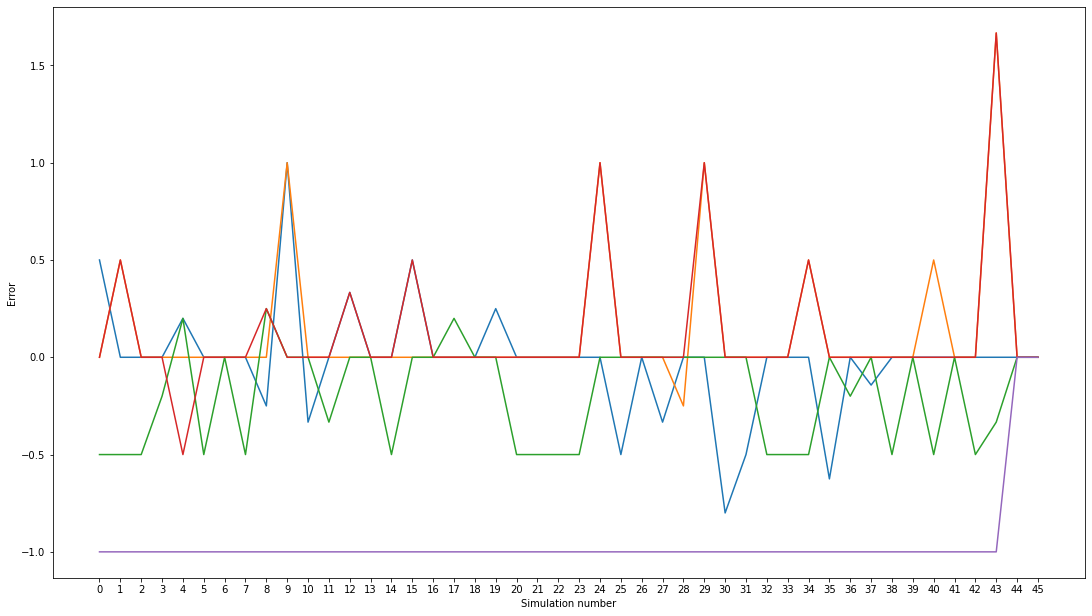

In [45]:

from matplotlib import pyplot as plt
for i in range(data.shape[0]):
    plt.plot([j for j in range(data.shape[1])], error[i])
plt.xticks([j for j in range(data.shape[1])])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xlabel("Simulation number")
plt.ylabel("Error")
plt.show()

This is the average per scree plot. 

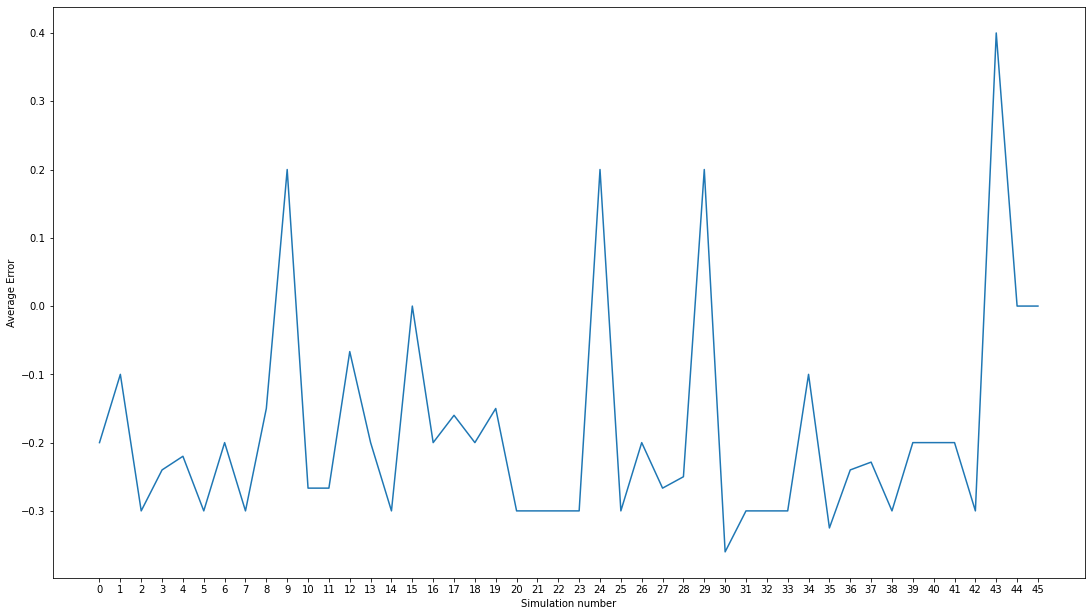

In [46]:
plt.plot([j for j in range(data.shape[1])], np.mean(error, axis=0))
plt.xticks([j for j in range(data.shape[1])])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xlabel("Simulation number")
plt.ylabel("Average Error")
plt.show()

# Using PCA and LDA in order to find the elbow

first fit PCA with d = n (the number of cols in input array)

Then run LDA on that embedded data using the PCA version of A and the y from original data set

Then per dimension(first, the first dimension. Second, the first two dimensions. Third, the first three dimensions, etc) calculate the missclassification rate. Plot the missclassification rate vs dimension. 



In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

all_miss = []
for i in range(len(all_data)):
    print(i)
    ad = all_data[i]
    pca = PCA(n_components=min(ad.shape[1], ad.shape[0]))
    b = pca.fit_transform(ad)
    ay = np.nan_to_num(np.asarray(all_ys[i]))
    X_train, X_test, y_train, y_test = train_test_split(b, ay, test_size=0.33, random_state=42)
    miss_per_dim = []
    for j in range(X_train.shape[1]):
        
        clf = LDA()
        clf.fit(X_train[:, :j+1], y_train)
        pred = clf.predict(X_test[:, :j+1])
        miss_per_dim.append(np.mean(pred != y_test))
    all_miss.append(miss_per_dim)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


In [48]:
with open('SMALL_all_miss.pkl', 'wb') as f:
    pickle.dump(all_miss, f)


In [49]:
with open('SMALL_all_miss.pkl', 'rb') as f:
    all_miss = pickle.load(f) 

In [56]:
len(all_miss)

46

In [50]:
import seaborn as sns
import numpy as np
colors = sns.color_palette()    
def scree_2(miss, ds, idx):
    sns.lineplot(x = np.arange(len(miss)), y = miss)
    if max(miss) > .5:
        plt.ylim(0, max(miss) + .1) 
    else:
        plt.ylim(0, .5)
    locs = []
    added = set()
    for i in range(len(ds)):
        noise = 0
        if ds[i] in added:
            while(abs(noise) < .1 ):
                noise = np.random.normal(.1, .2)
            added.add(ds[i])
        locs.append(ds[i] + noise)
    plt.axvline(idx, label='true:{}'.format(idx), color='red', linewidth = 8, alpha = .3, zorder =  0)
    plt.axvline(locs[0], label='ZG(1):{}'.format(ds[0]), color=colors[0], ls='--', zorder =  1)
    plt.axvline(locs[1], label='ZG(2):{}'.format(ds[1]), color=colors[0], ls=':', zorder =  1)
    plt.axvline(locs[2], label='minka:{}'.format(ds[2]), color=colors[1], ls='--', zorder =  1)
    plt.axvline(locs[3], label='ZG_hack(1):{}'.format(ds[3]), color= colors[2], ls='--', zorder =  1)
    plt.axvline(locs[4], label='ZG_hack(2):{}'.format(ds[4]), color=colors[2], ls=':', zorder =  1)
    plt.title("Missclassification rate per PCA dimension(d = " + str(len(miss)) + ")")
    plt.xlabel("Dimension")
    plt.ylabel("Missclassification rate")
    fig = plt.gcf()    
    fig.set_size_inches(18.5, 10.5)
    plt.xticks(np.arange(len(miss)))
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left',)
    plt.show()
    plt.clf()

Missclassification rates vs Dimension

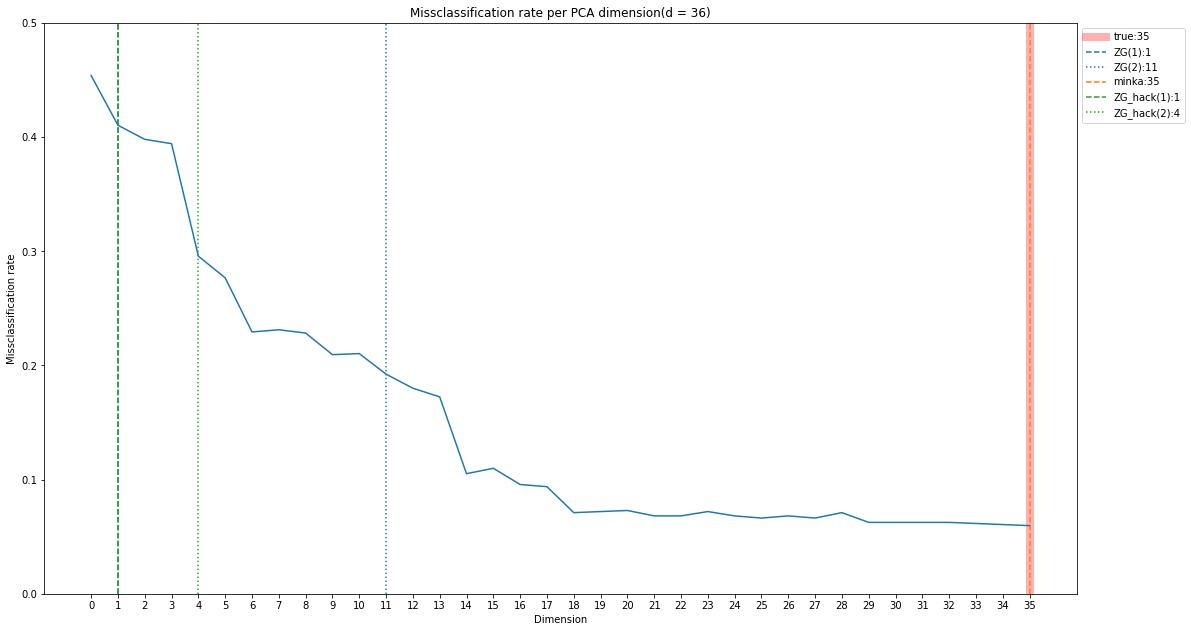

<Figure size 432x288 with 0 Axes>

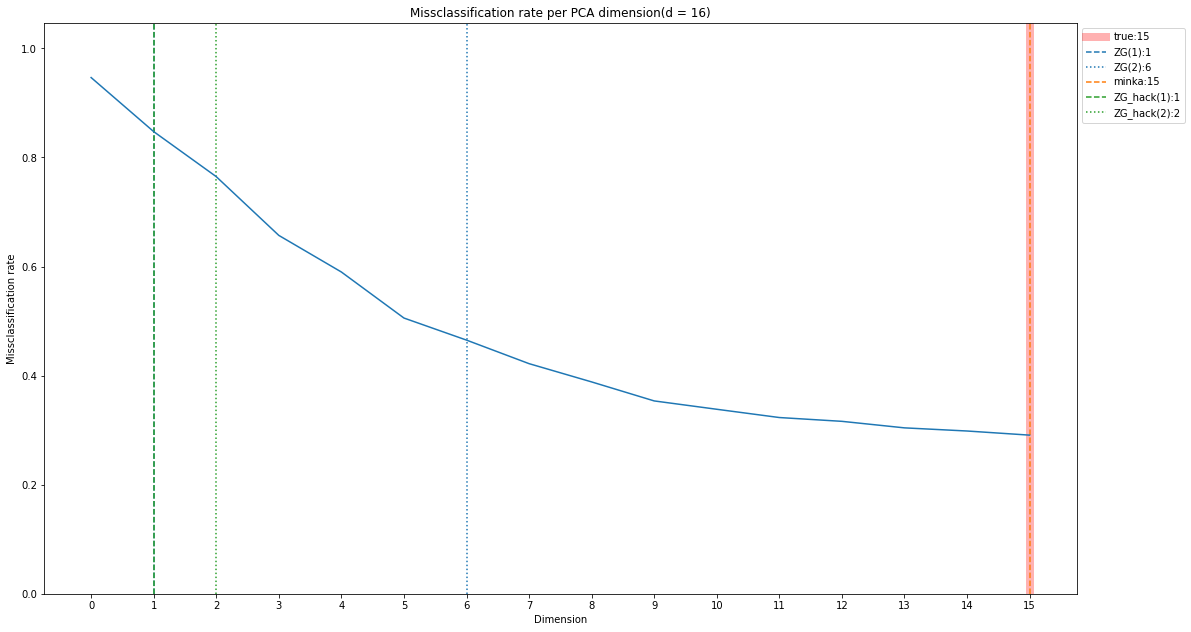

<Figure size 432x288 with 0 Axes>

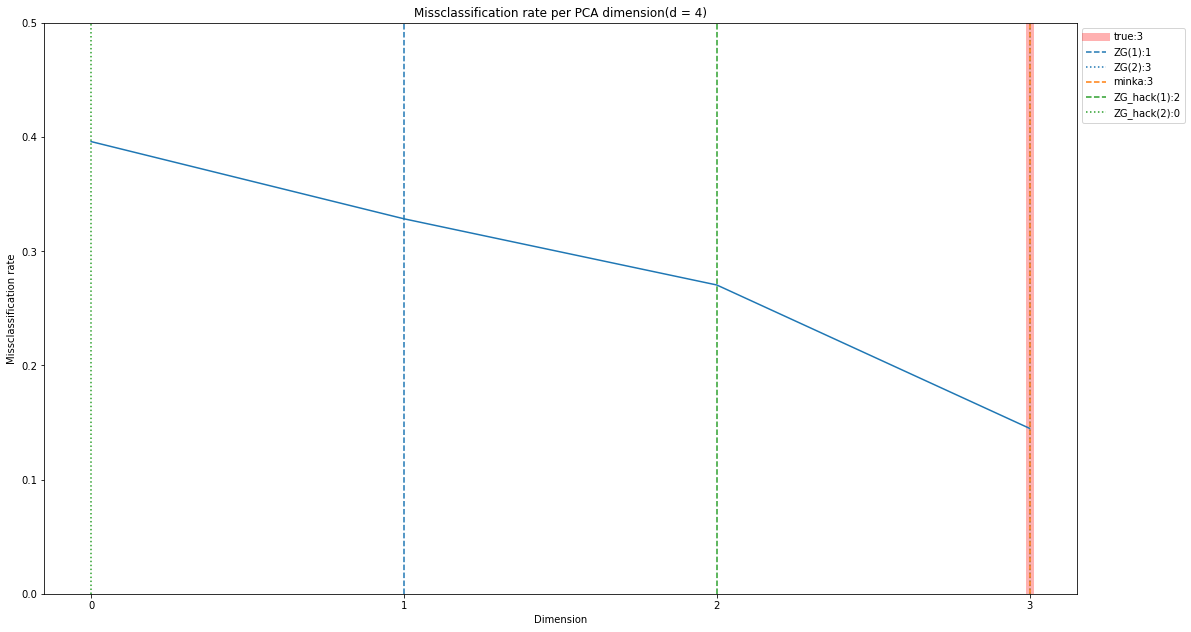

<Figure size 432x288 with 0 Axes>

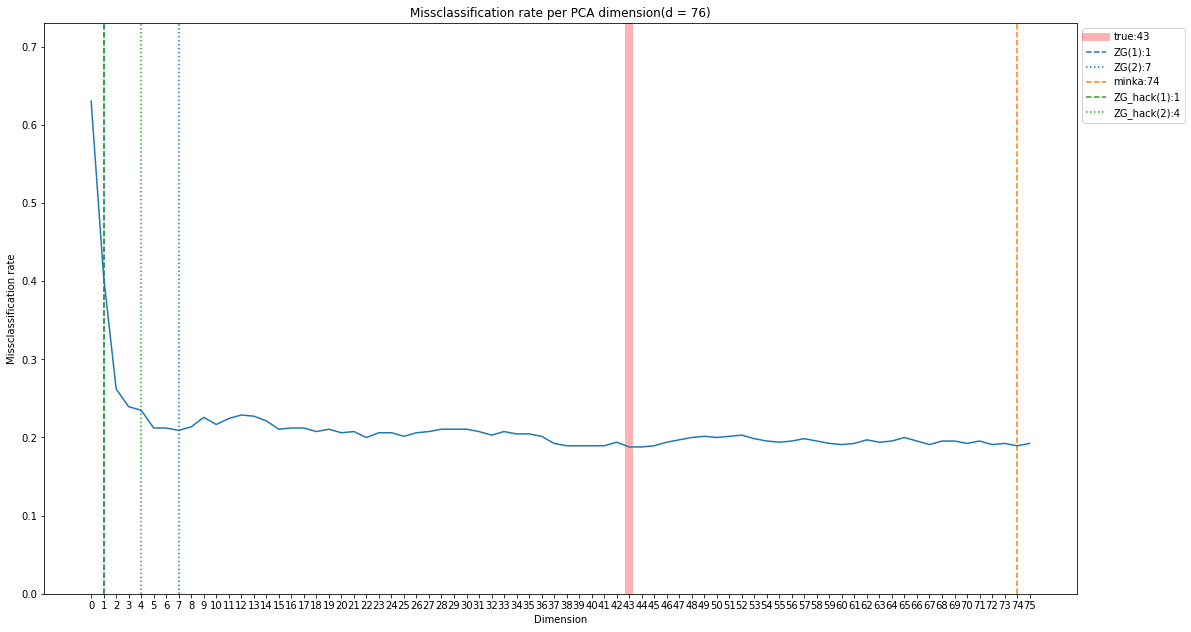

<Figure size 432x288 with 0 Axes>

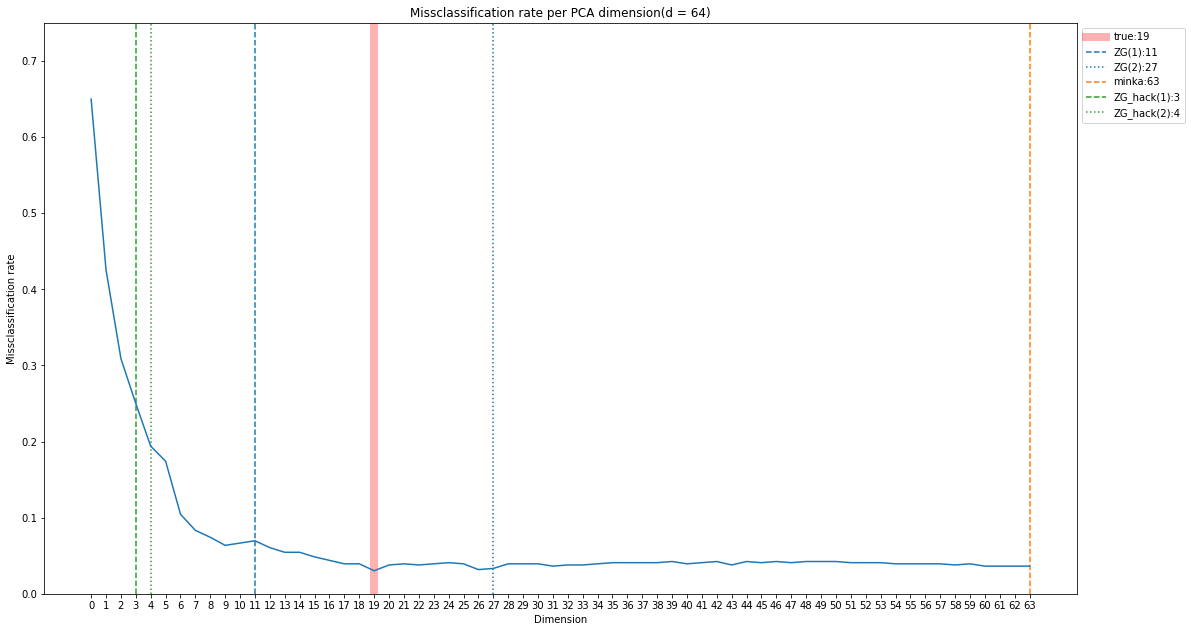

<Figure size 432x288 with 0 Axes>

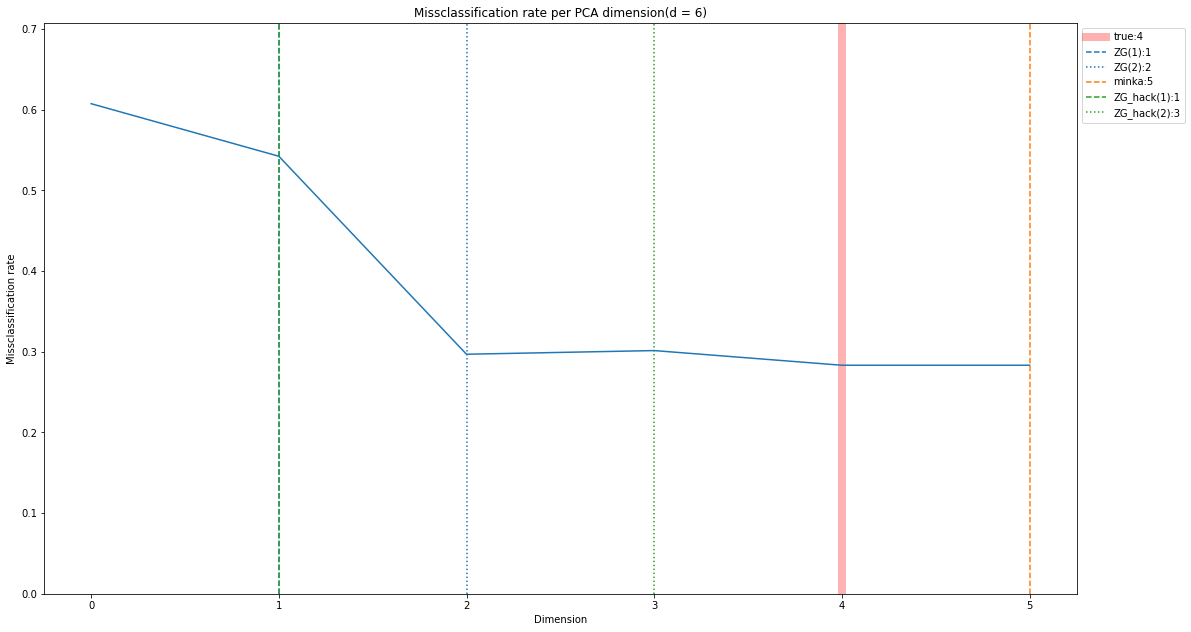

<Figure size 432x288 with 0 Axes>

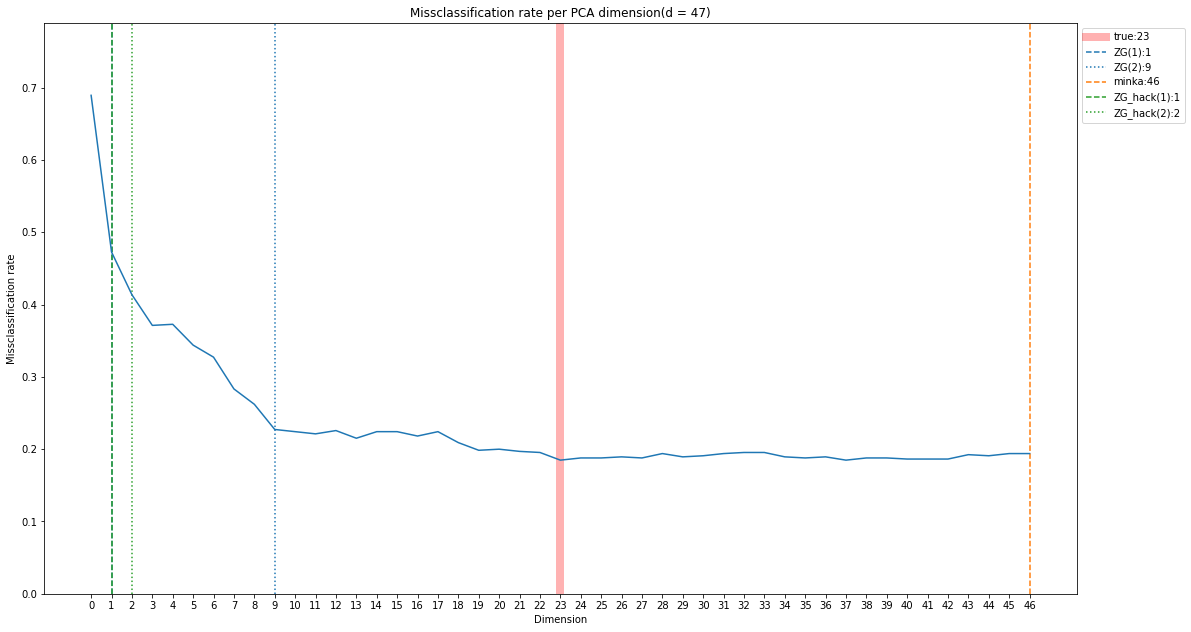

<Figure size 432x288 with 0 Axes>

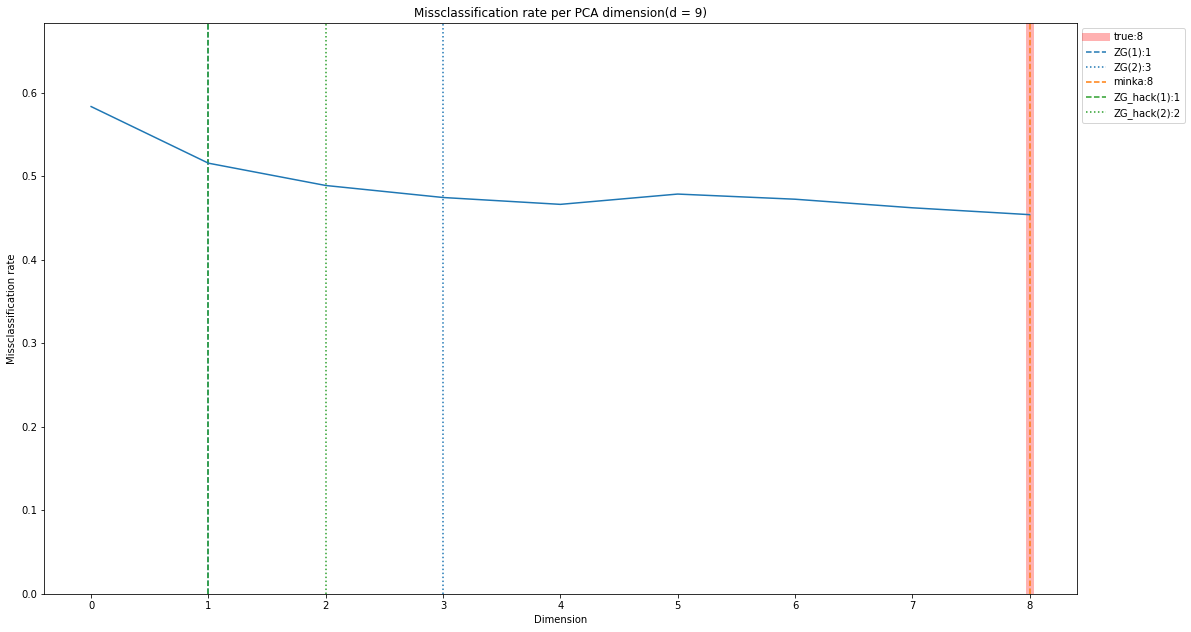

<Figure size 432x288 with 0 Axes>

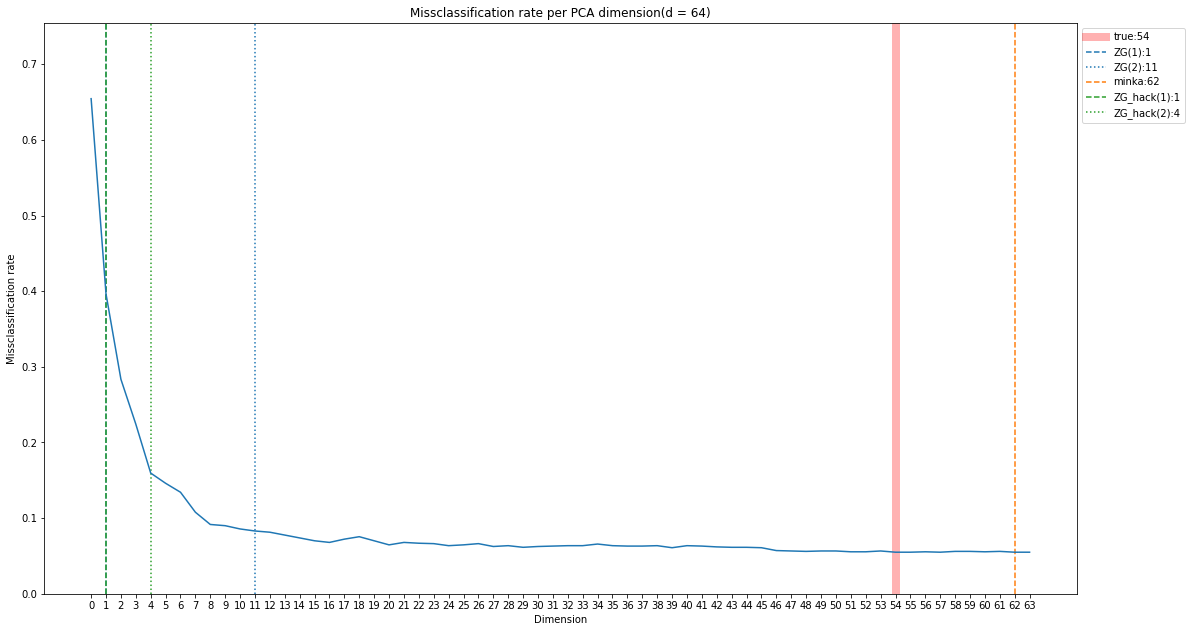

<Figure size 432x288 with 0 Axes>

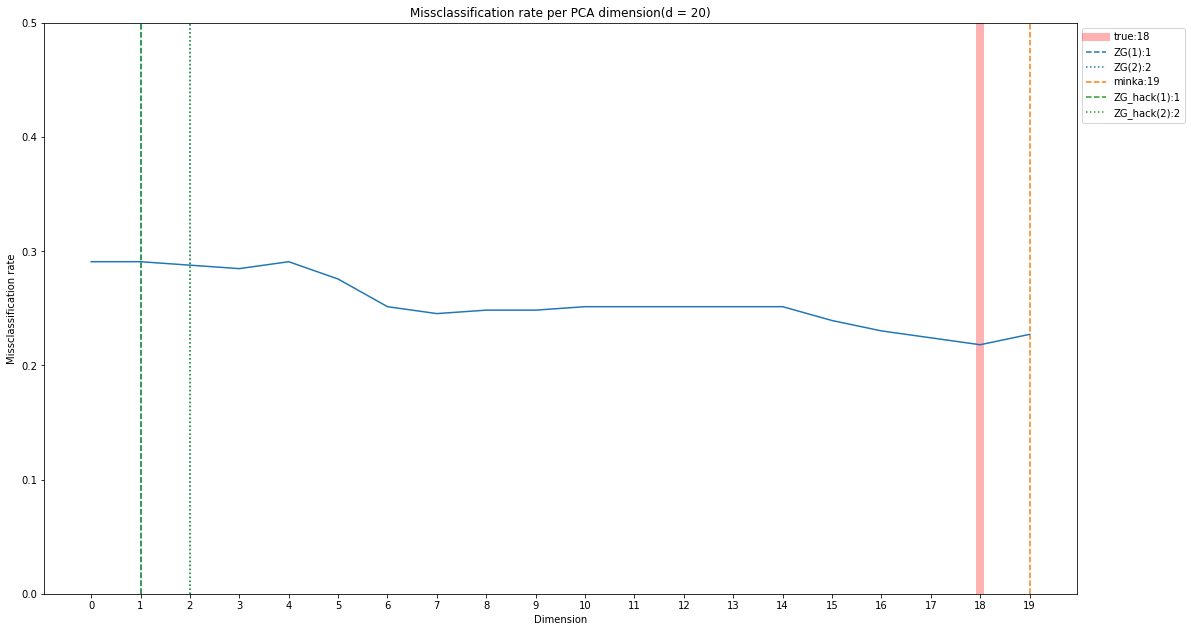

<Figure size 432x288 with 0 Axes>

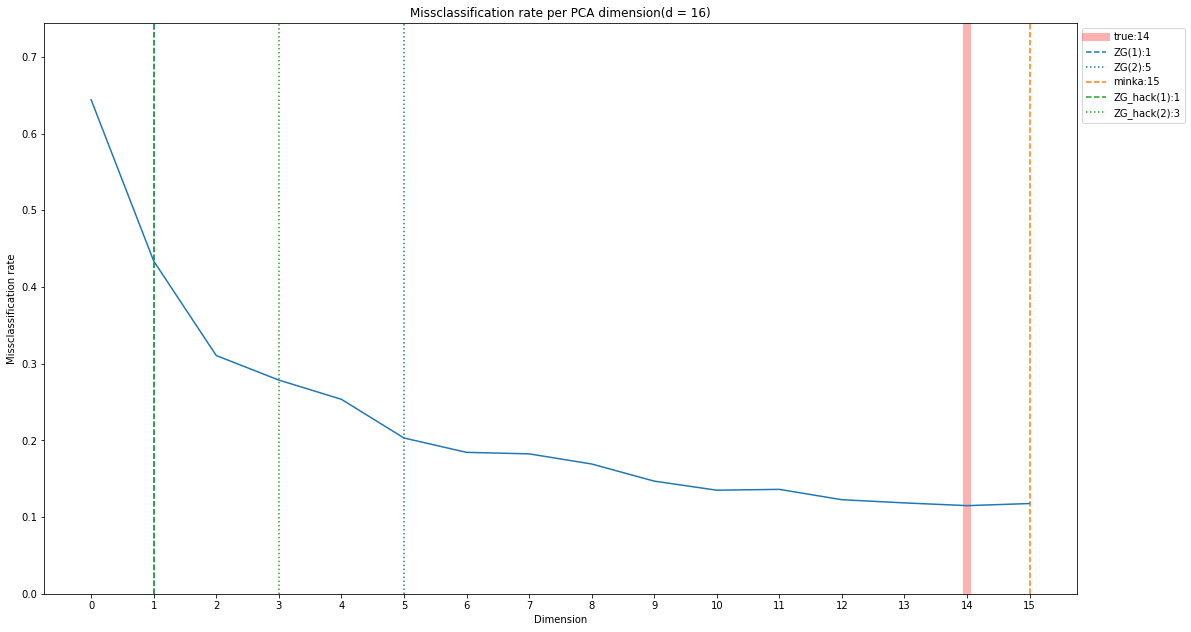

<Figure size 432x288 with 0 Axes>

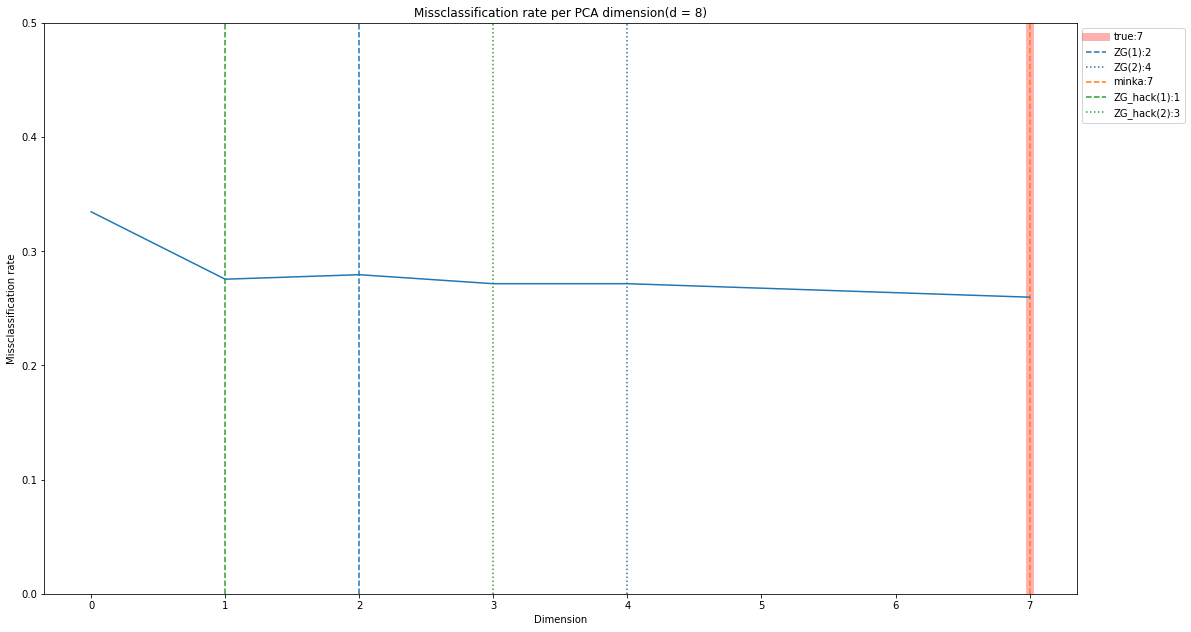

<Figure size 432x288 with 0 Axes>

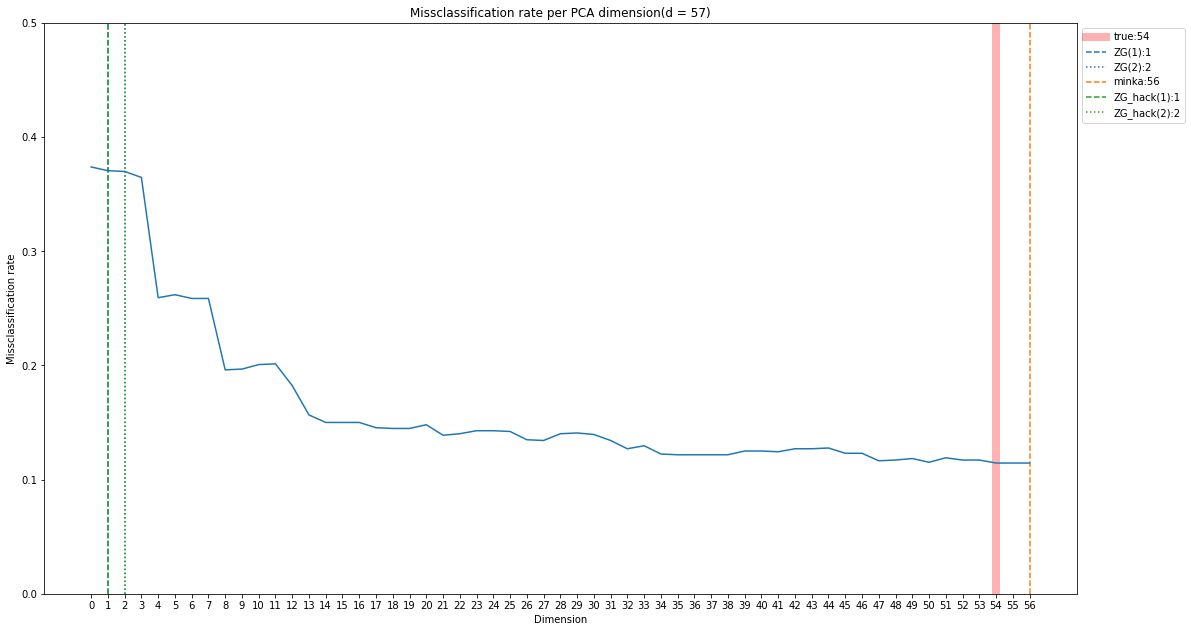

<Figure size 432x288 with 0 Axes>

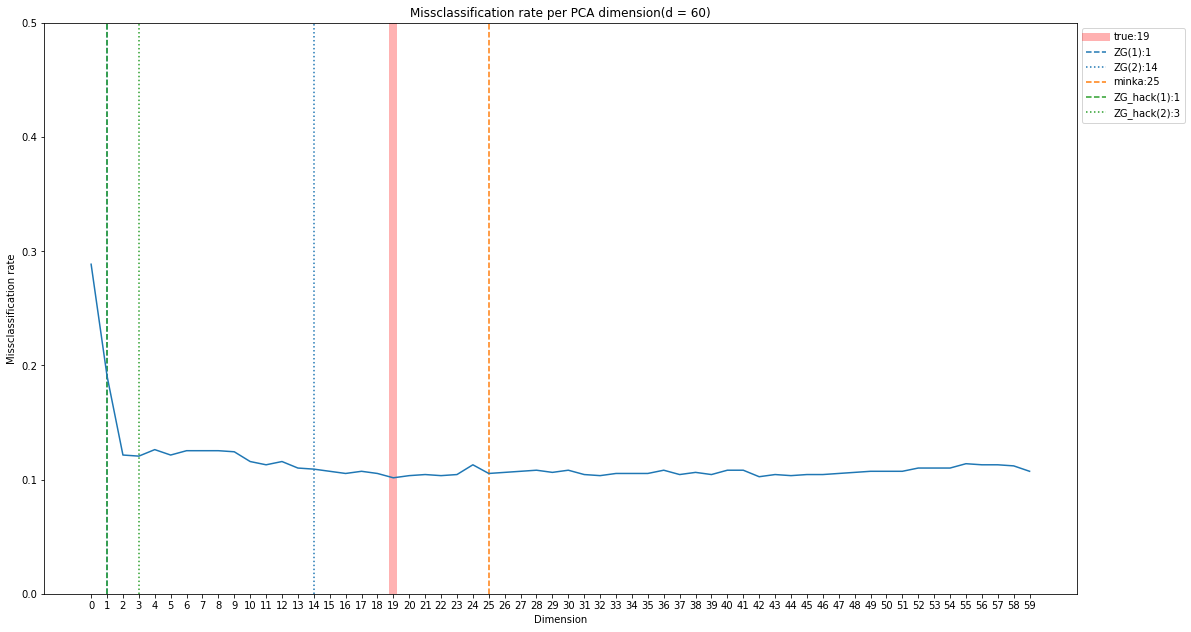

<Figure size 432x288 with 0 Axes>

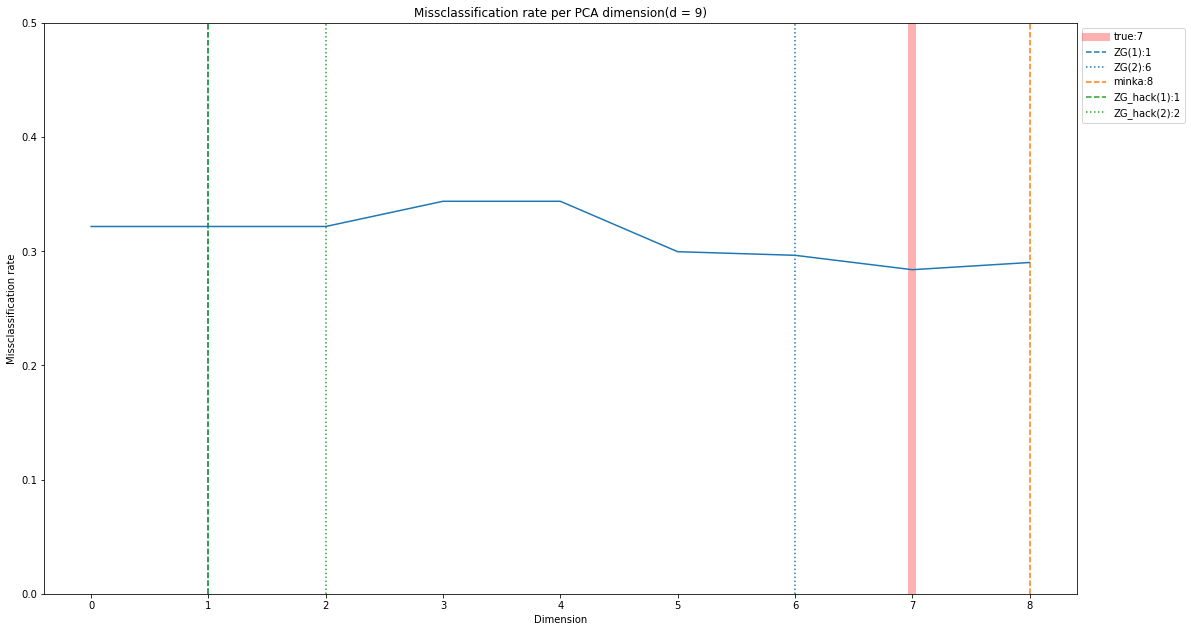

<Figure size 432x288 with 0 Axes>

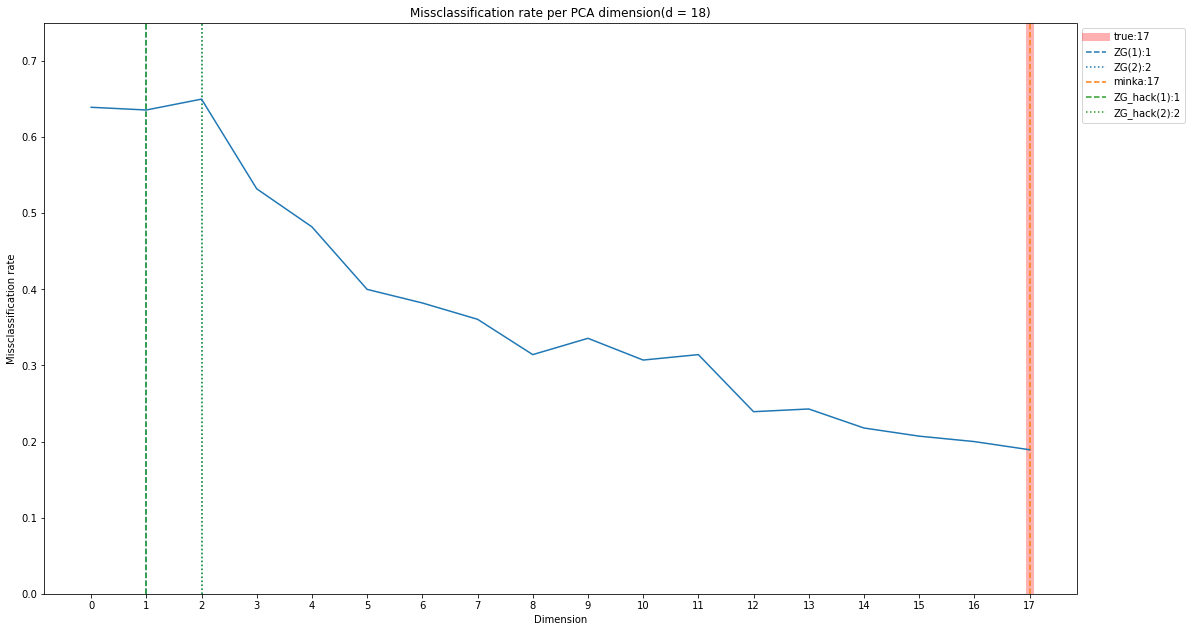

<Figure size 432x288 with 0 Axes>

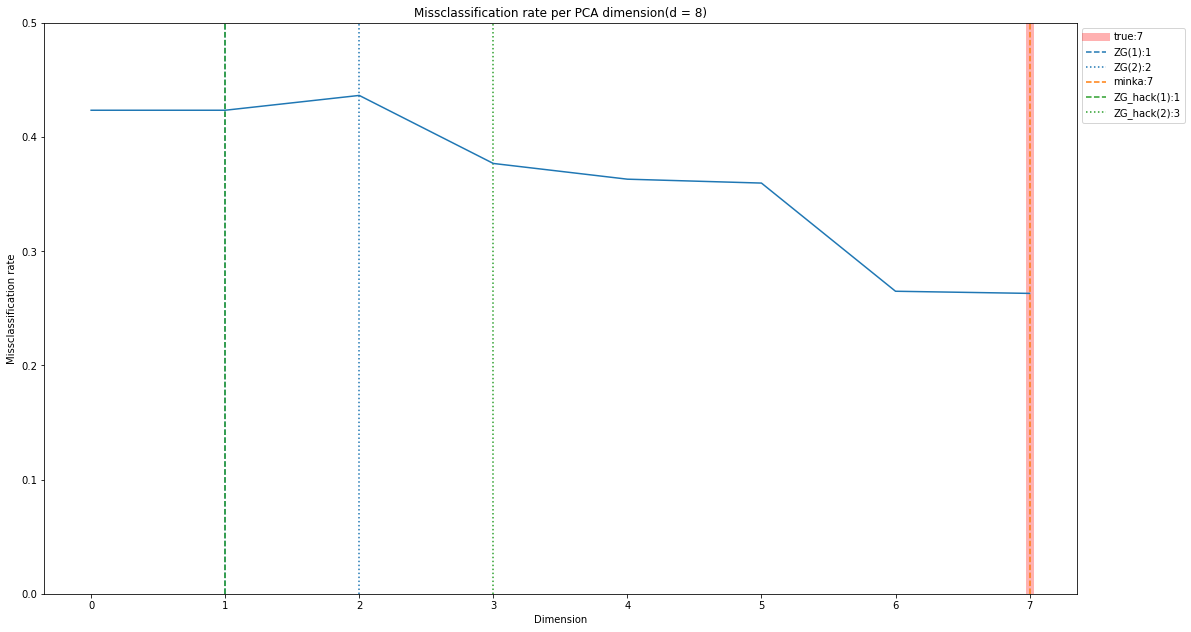

<Figure size 432x288 with 0 Axes>

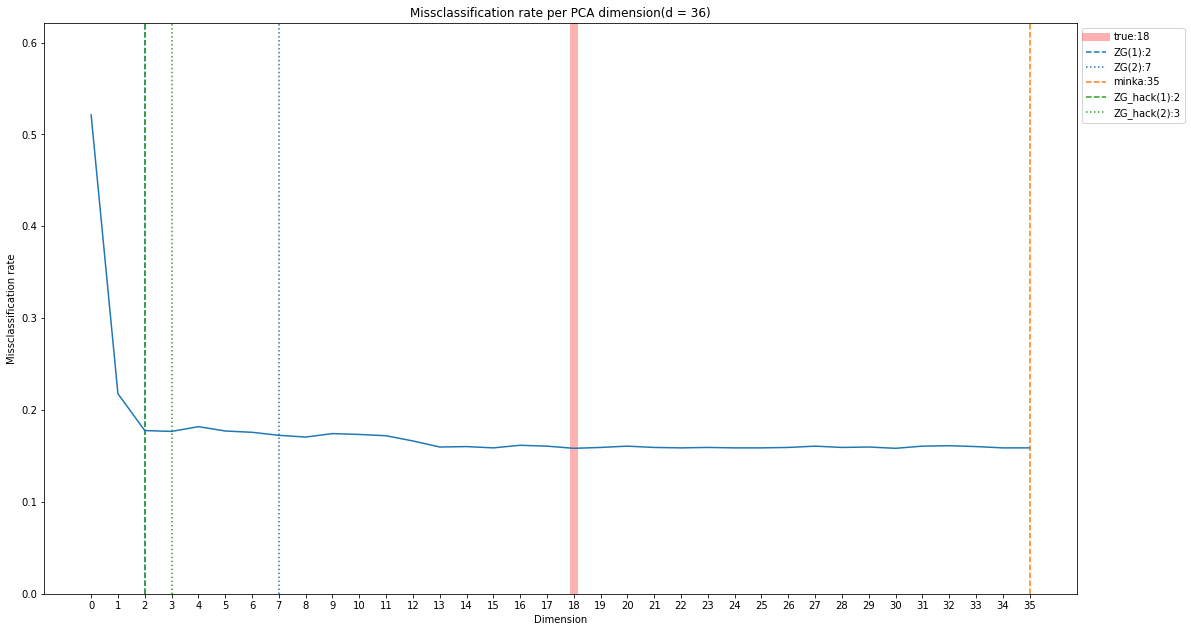

<Figure size 432x288 with 0 Axes>

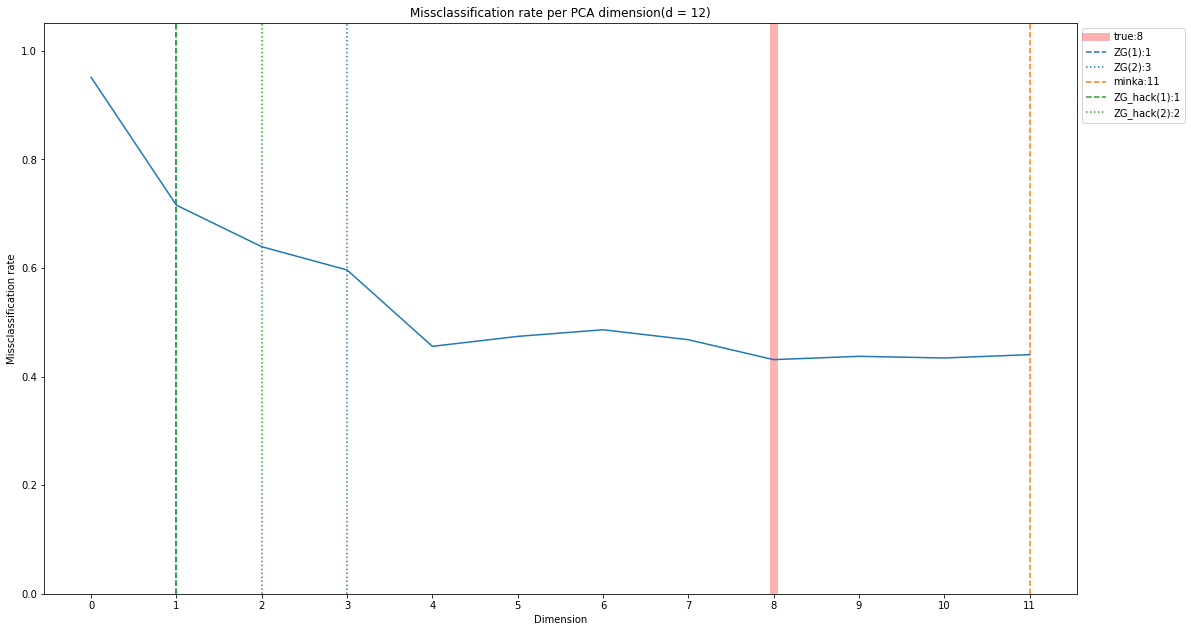

<Figure size 432x288 with 0 Axes>

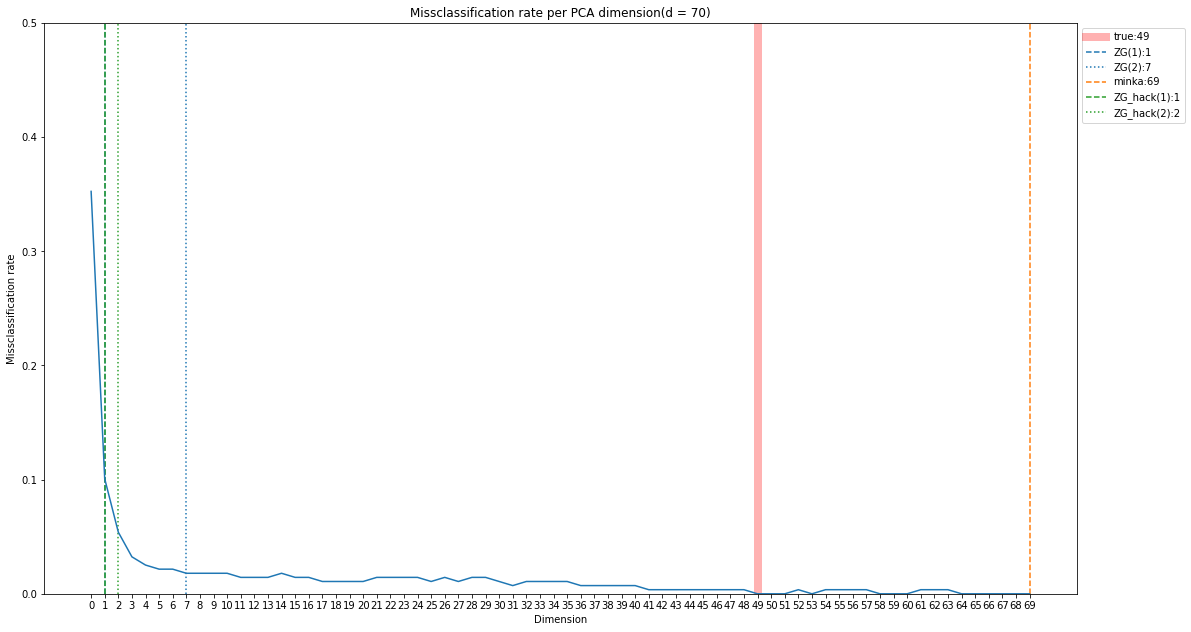

<Figure size 432x288 with 0 Axes>

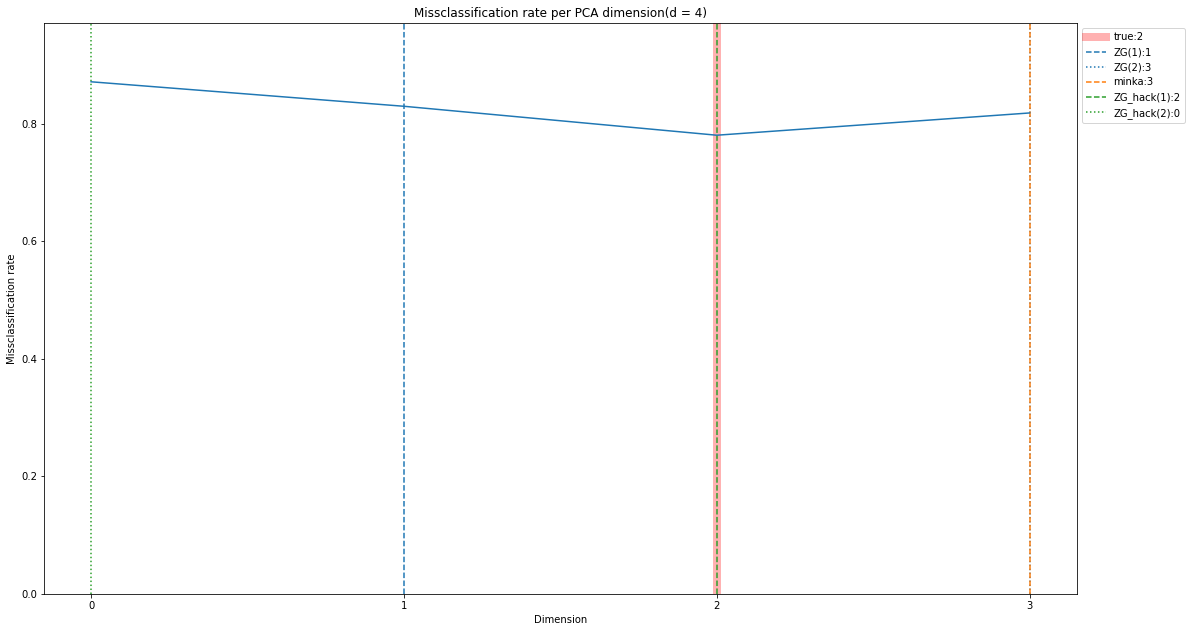

<Figure size 432x288 with 0 Axes>

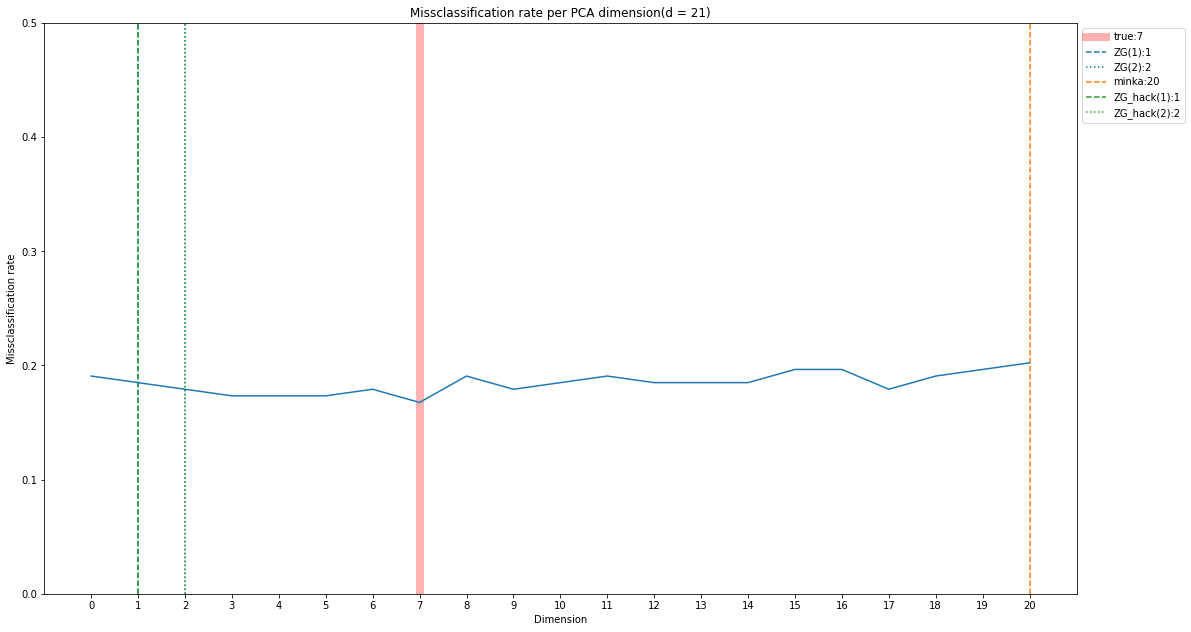

<Figure size 432x288 with 0 Axes>

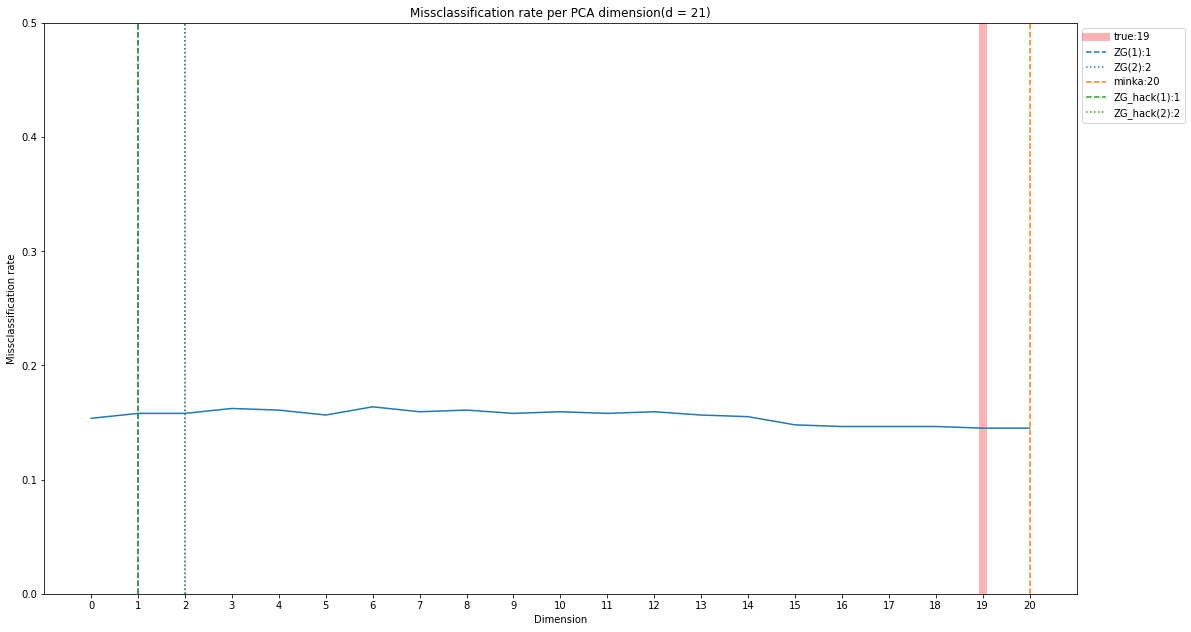

<Figure size 432x288 with 0 Axes>

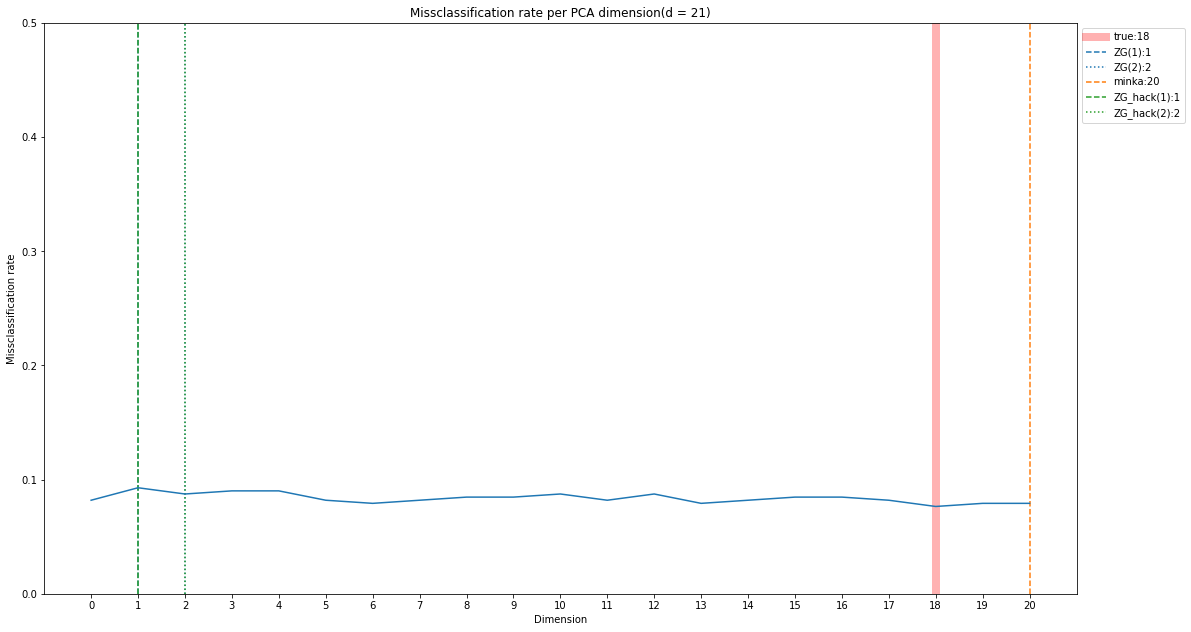

<Figure size 432x288 with 0 Axes>

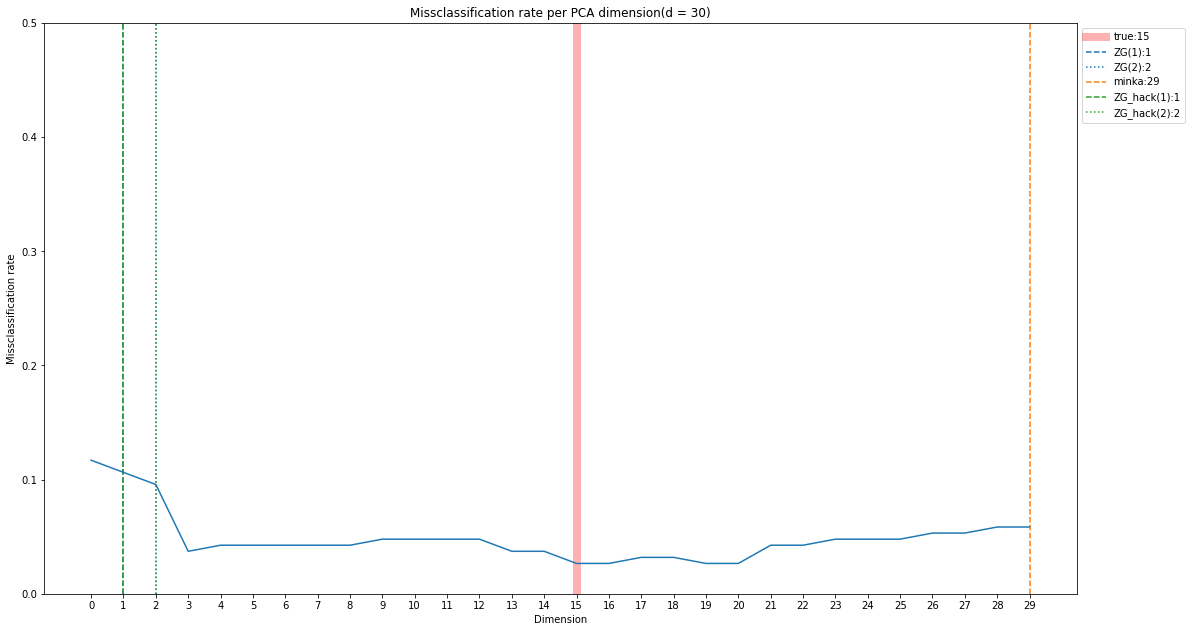

<Figure size 432x288 with 0 Axes>

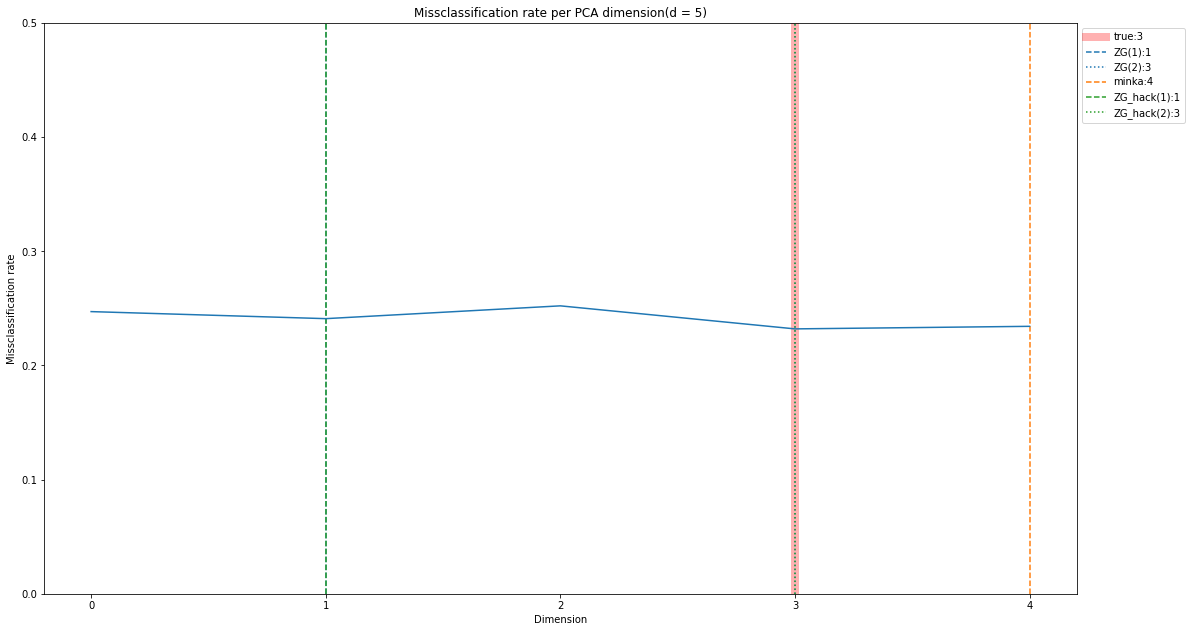

<Figure size 432x288 with 0 Axes>

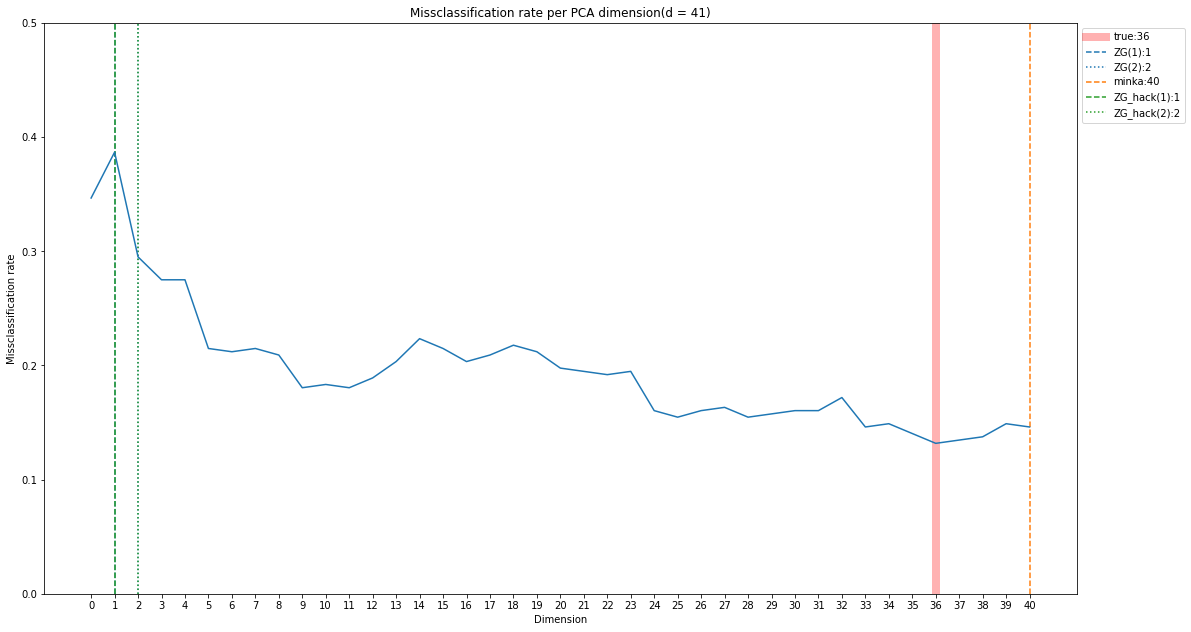

<Figure size 432x288 with 0 Axes>

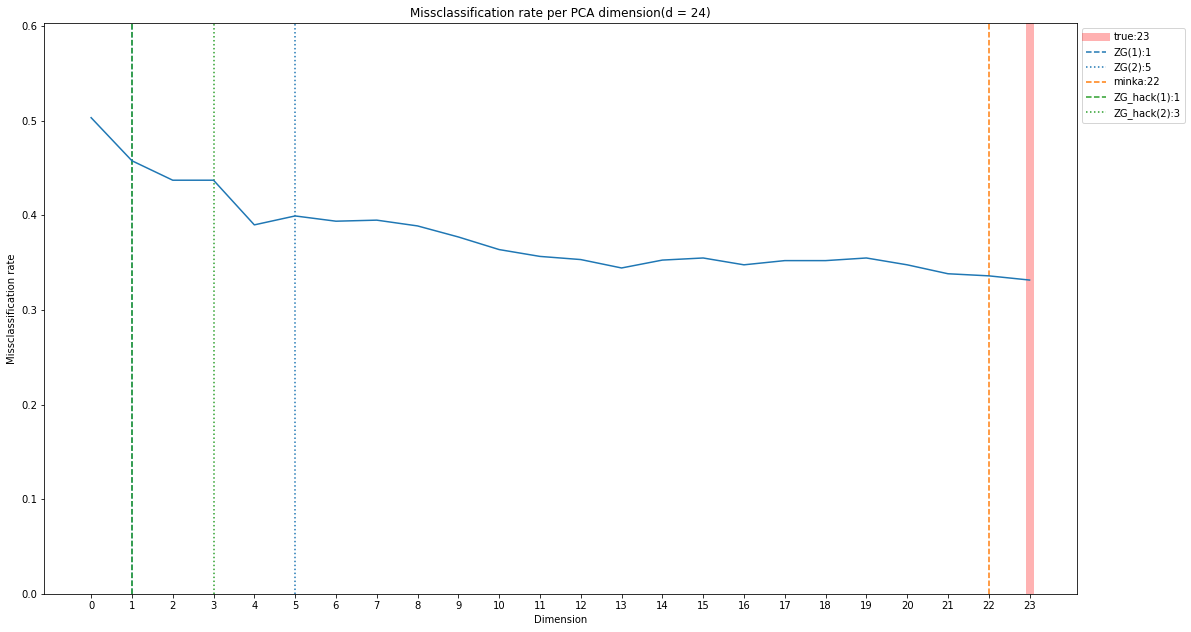

<Figure size 432x288 with 0 Axes>

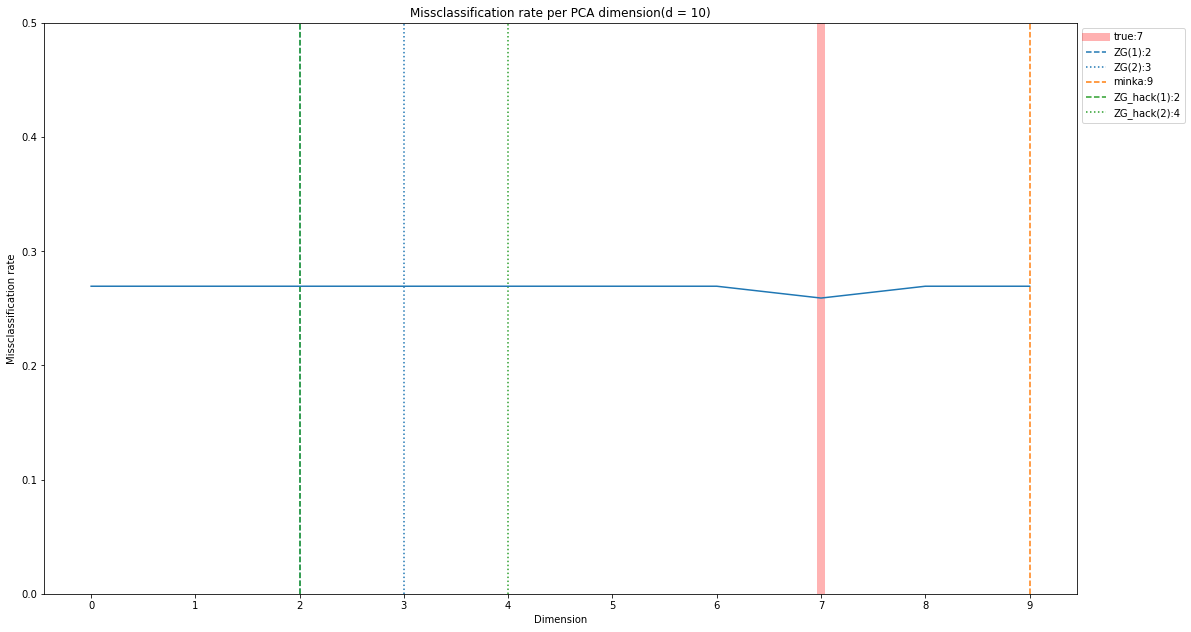

<Figure size 432x288 with 0 Axes>

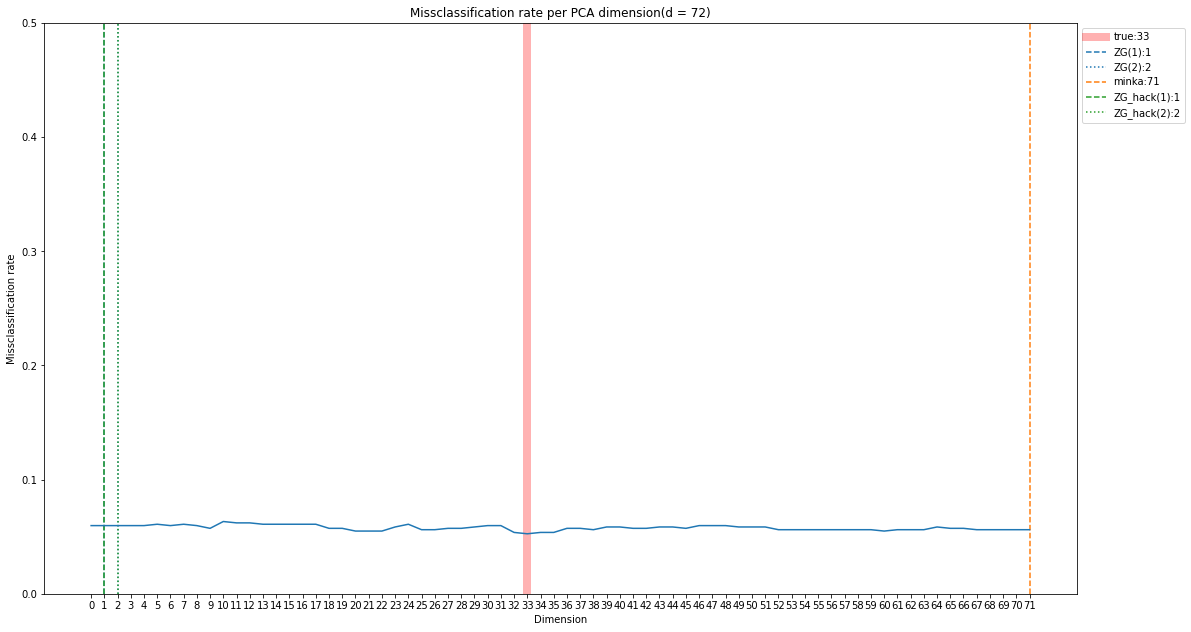

<Figure size 432x288 with 0 Axes>

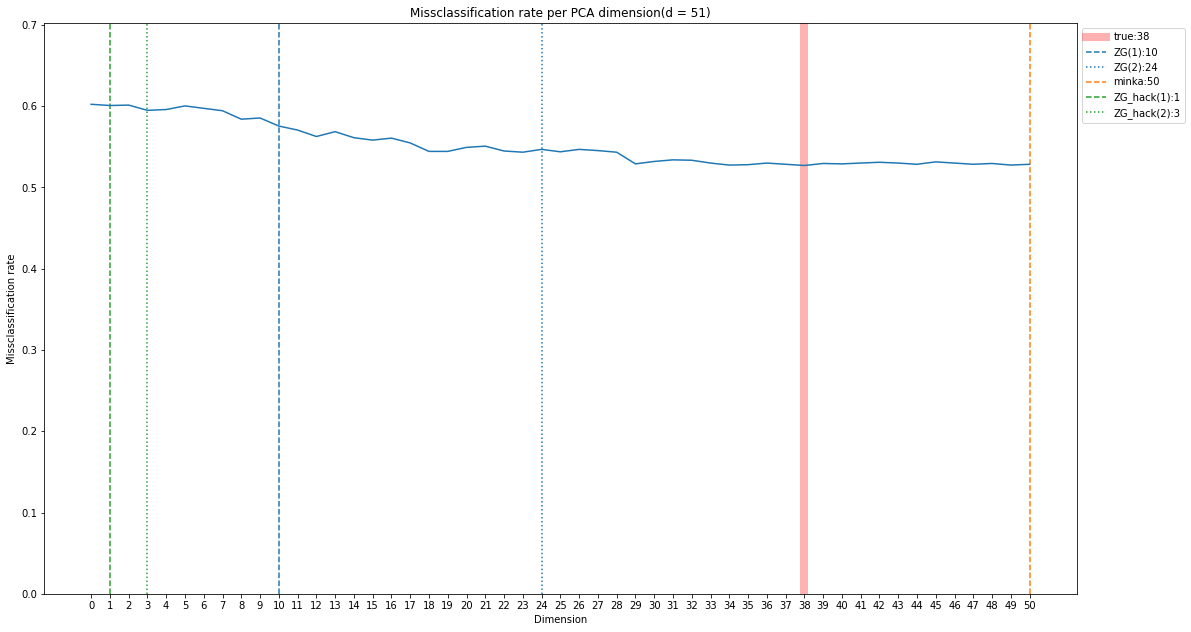

<Figure size 432x288 with 0 Axes>

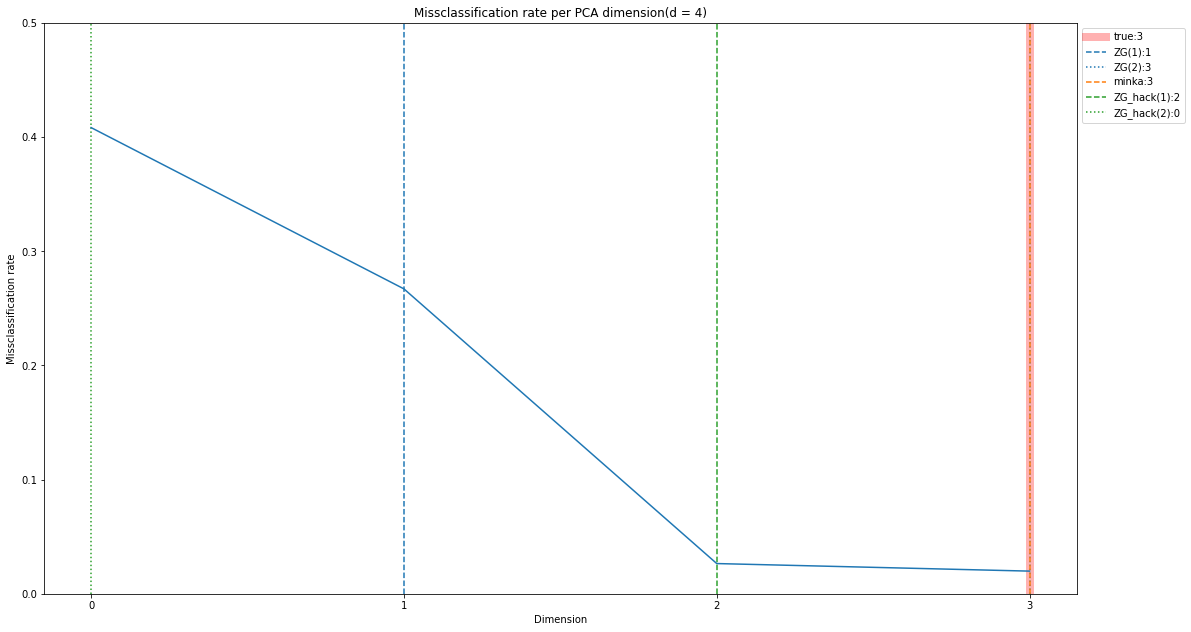

<Figure size 432x288 with 0 Axes>

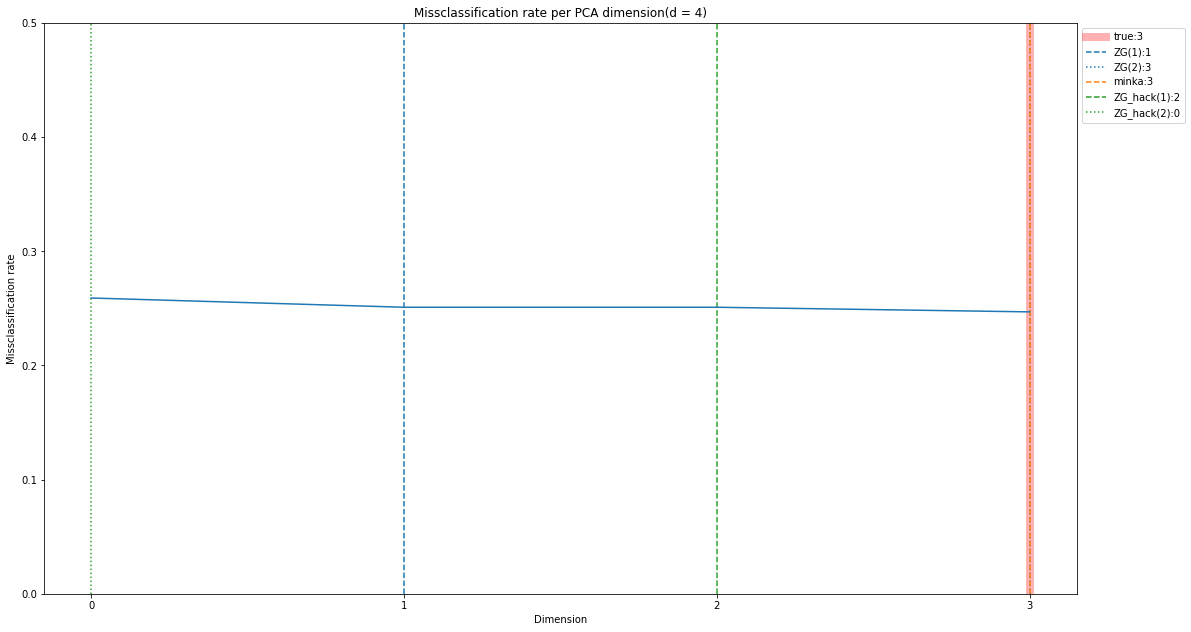

<Figure size 432x288 with 0 Axes>

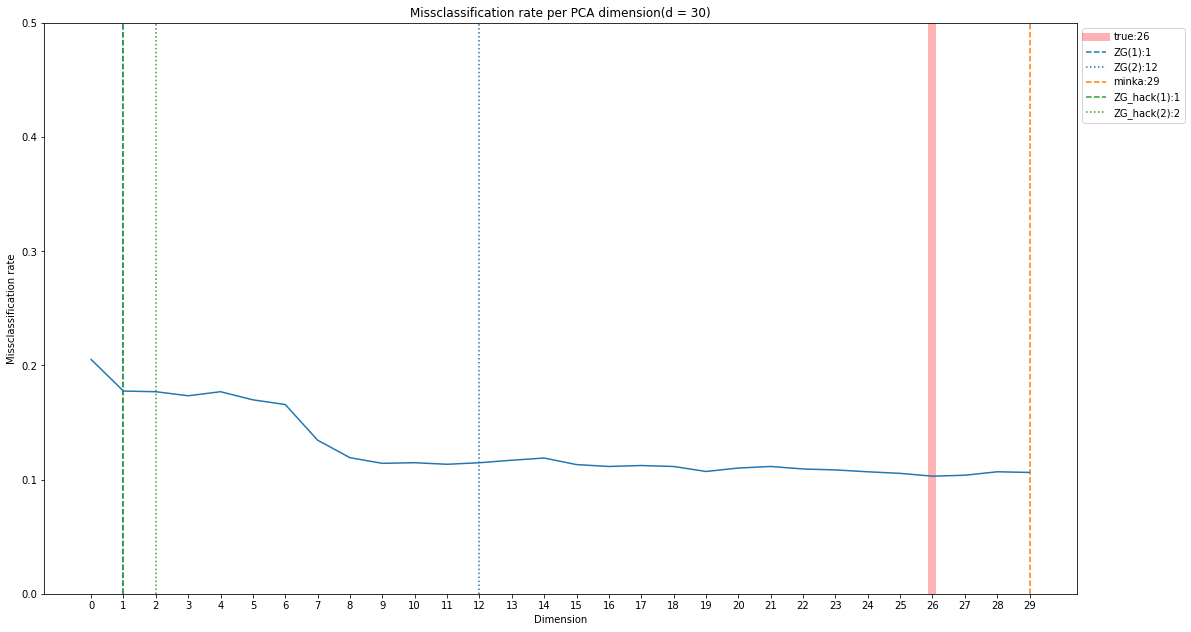

<Figure size 432x288 with 0 Axes>

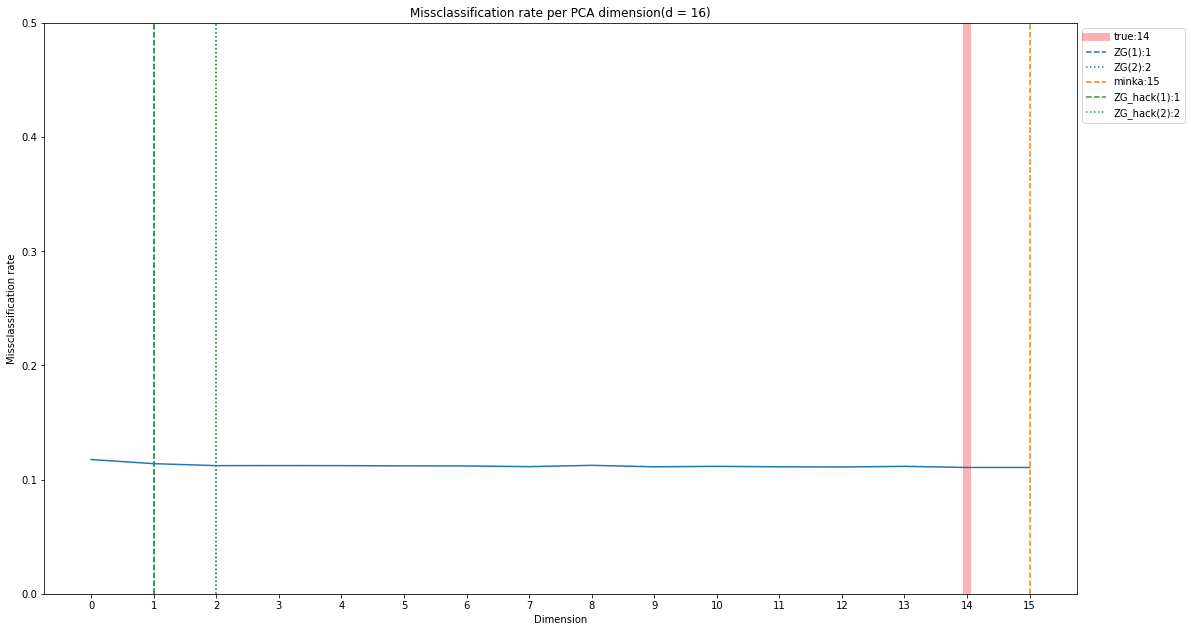

<Figure size 432x288 with 0 Axes>

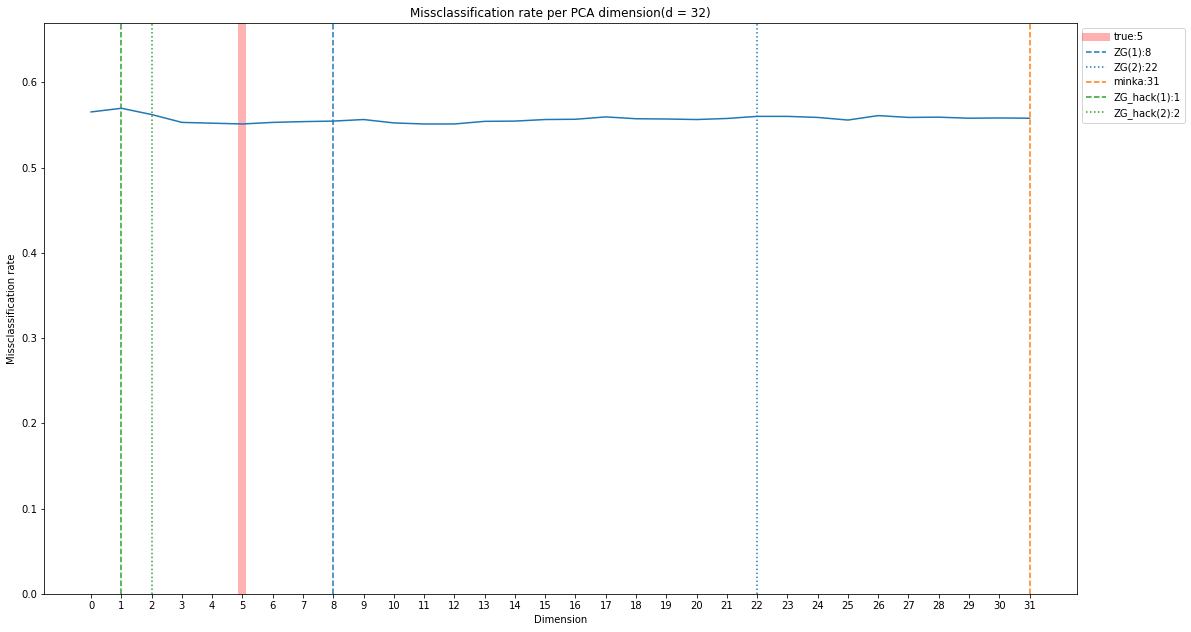

<Figure size 432x288 with 0 Axes>

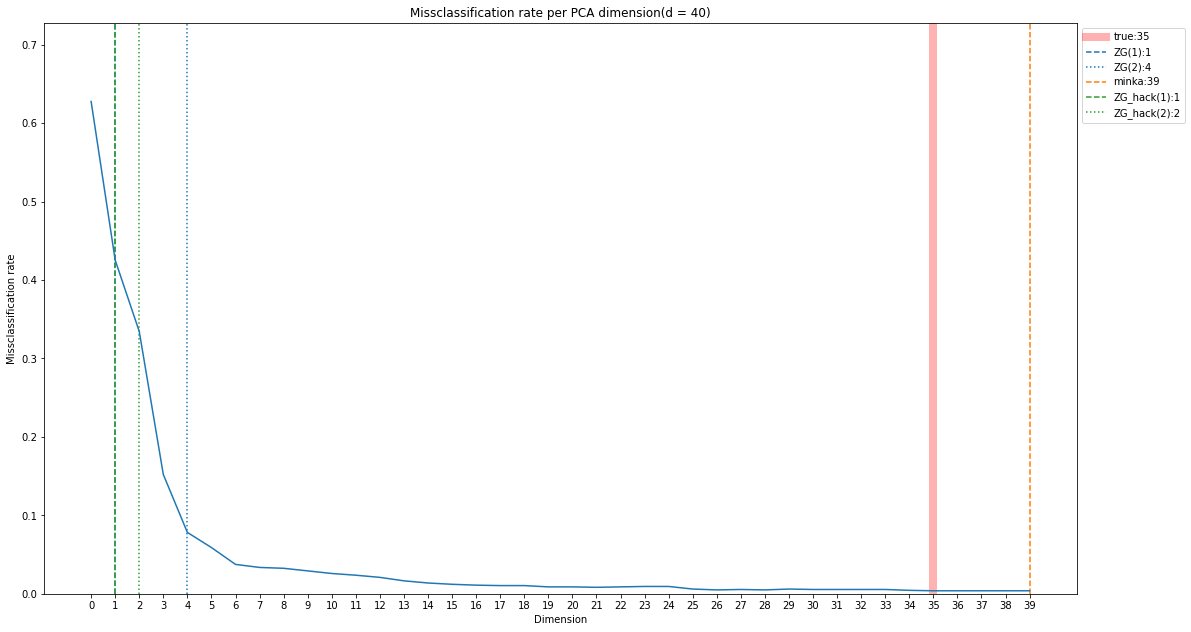

<Figure size 432x288 with 0 Axes>

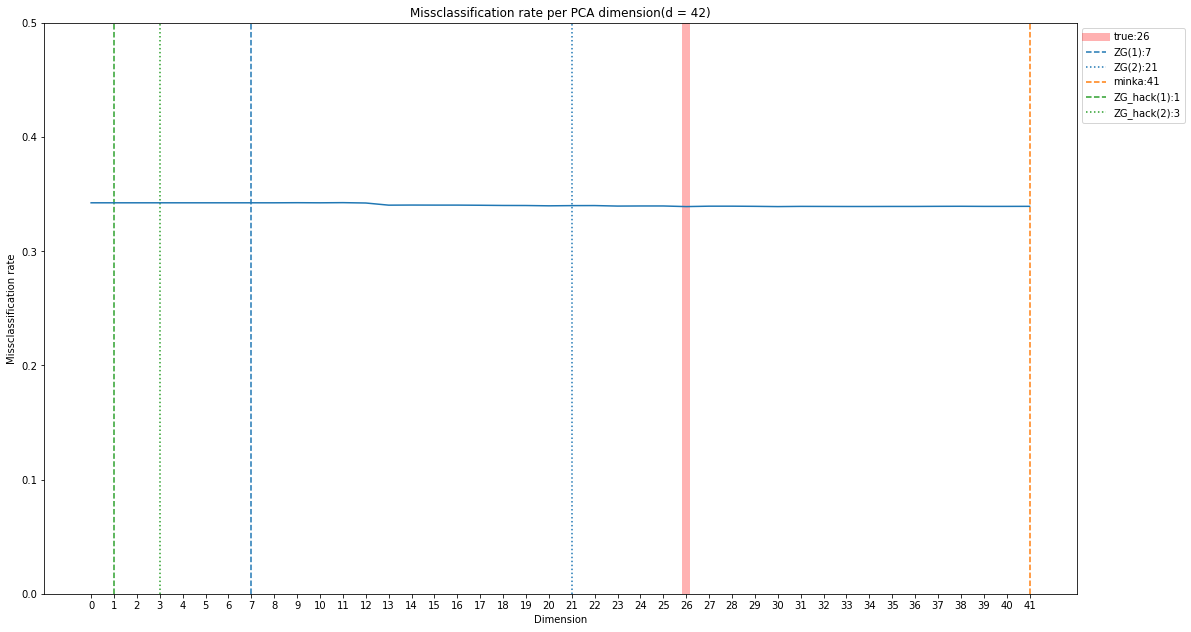

<Figure size 432x288 with 0 Axes>

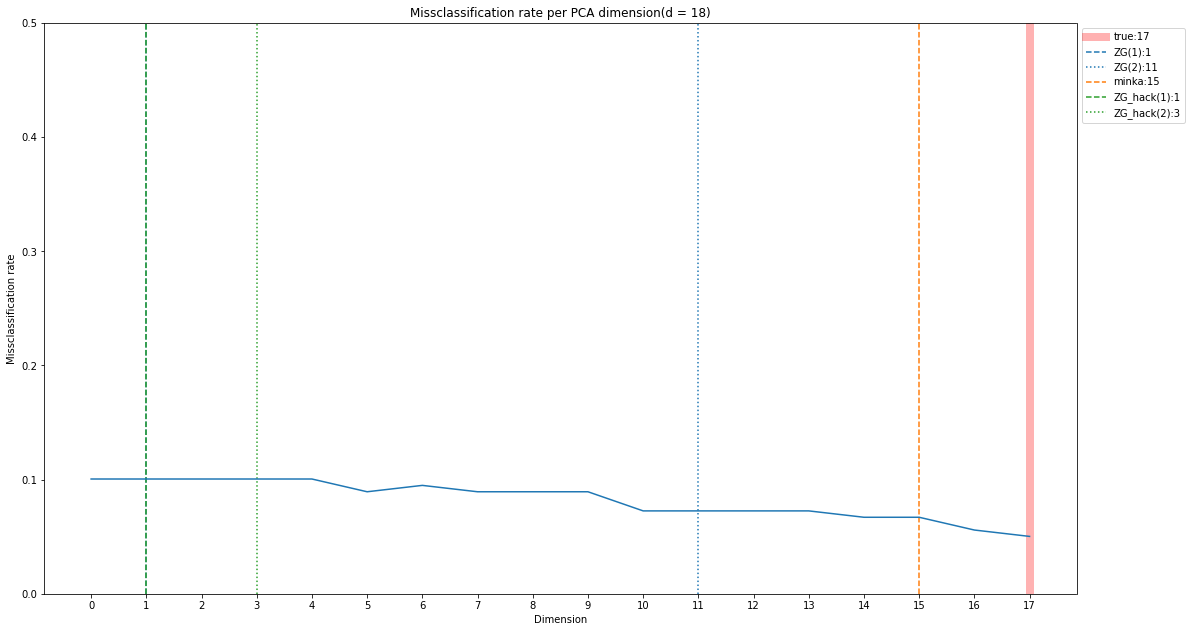

<Figure size 432x288 with 0 Axes>

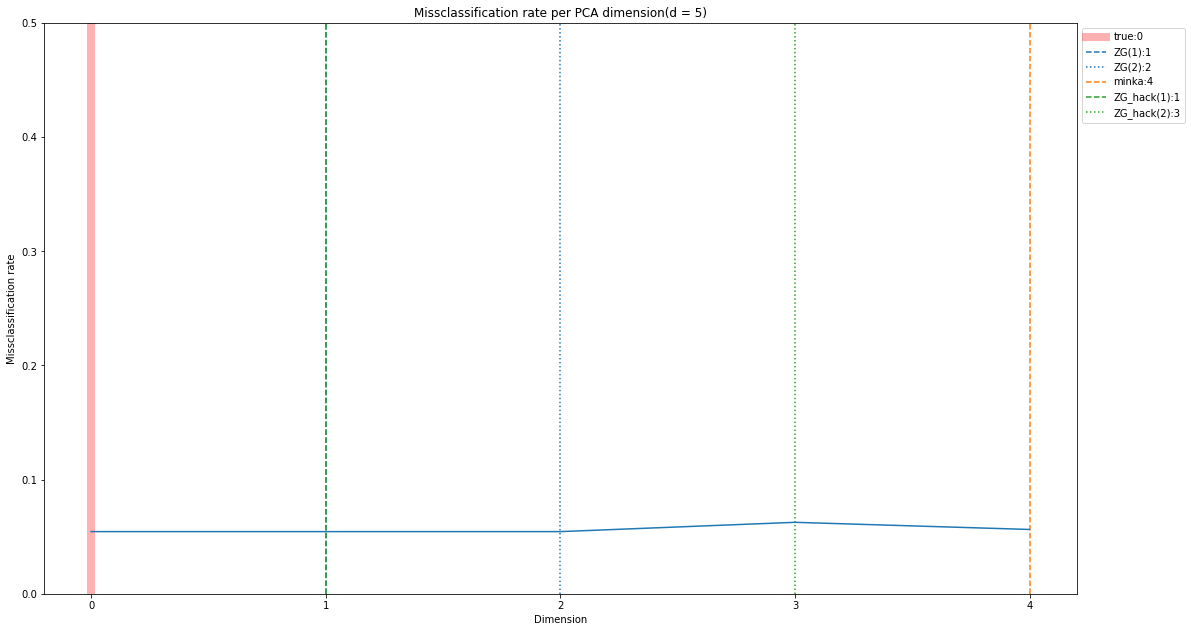

<Figure size 432x288 with 0 Axes>

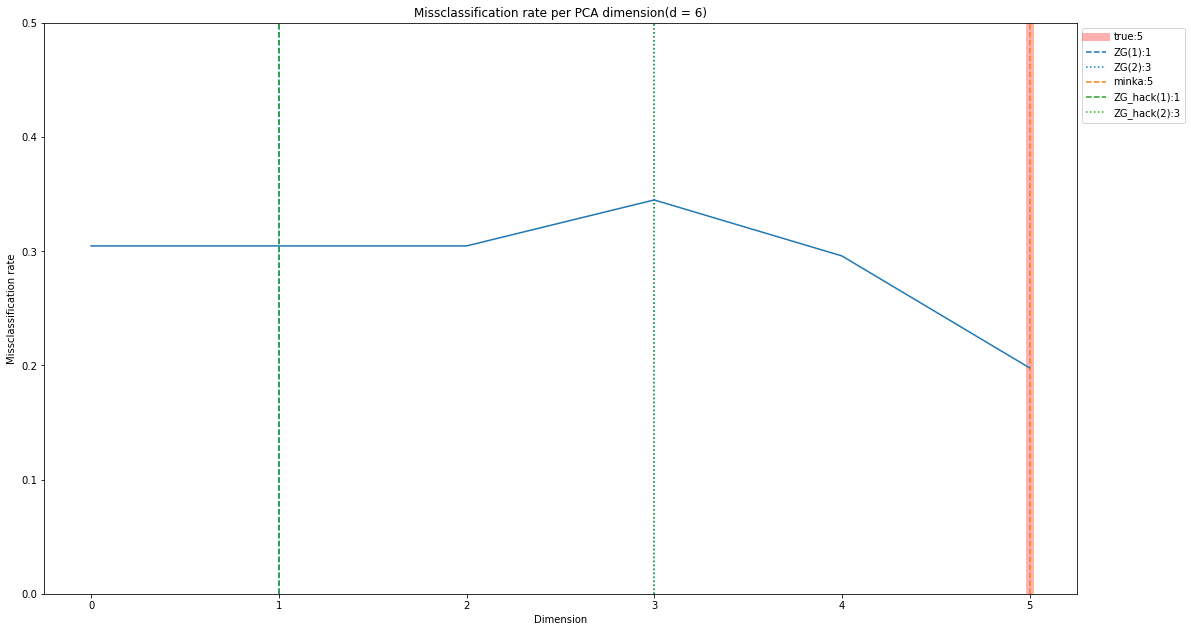

<Figure size 432x288 with 0 Axes>

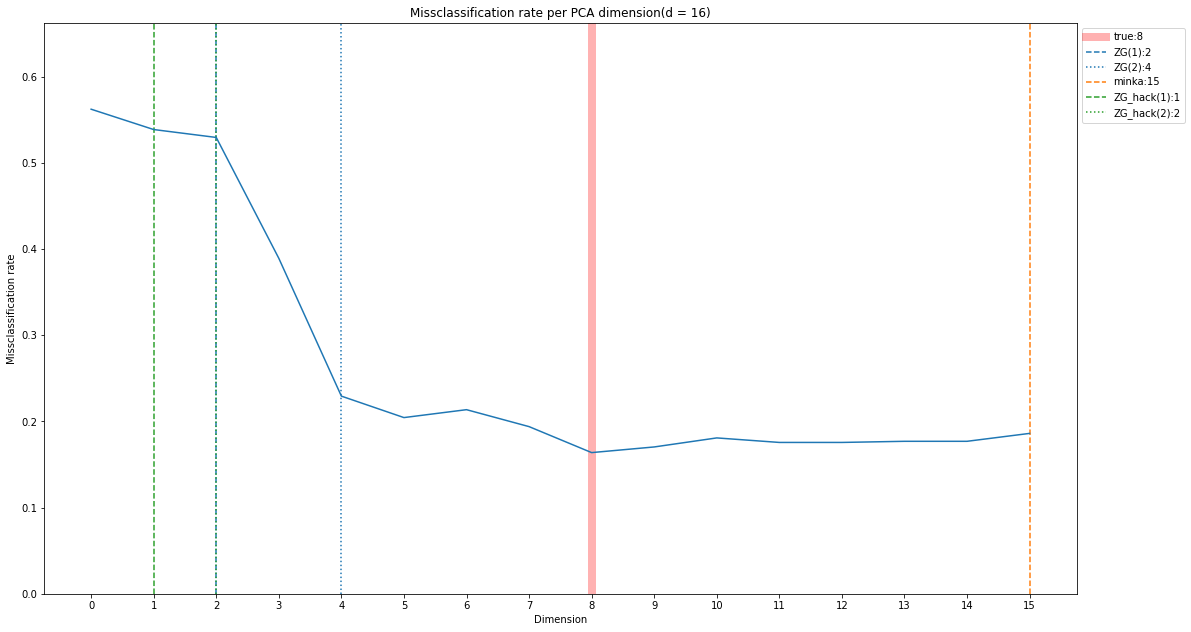

<Figure size 432x288 with 0 Axes>

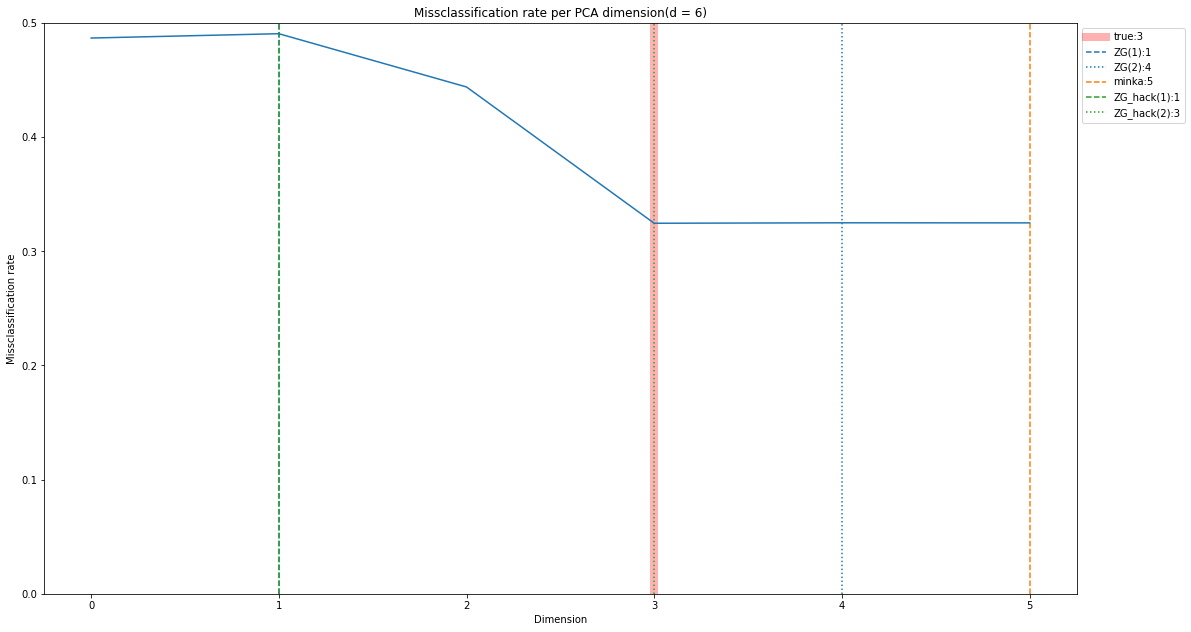

<Figure size 432x288 with 0 Axes>

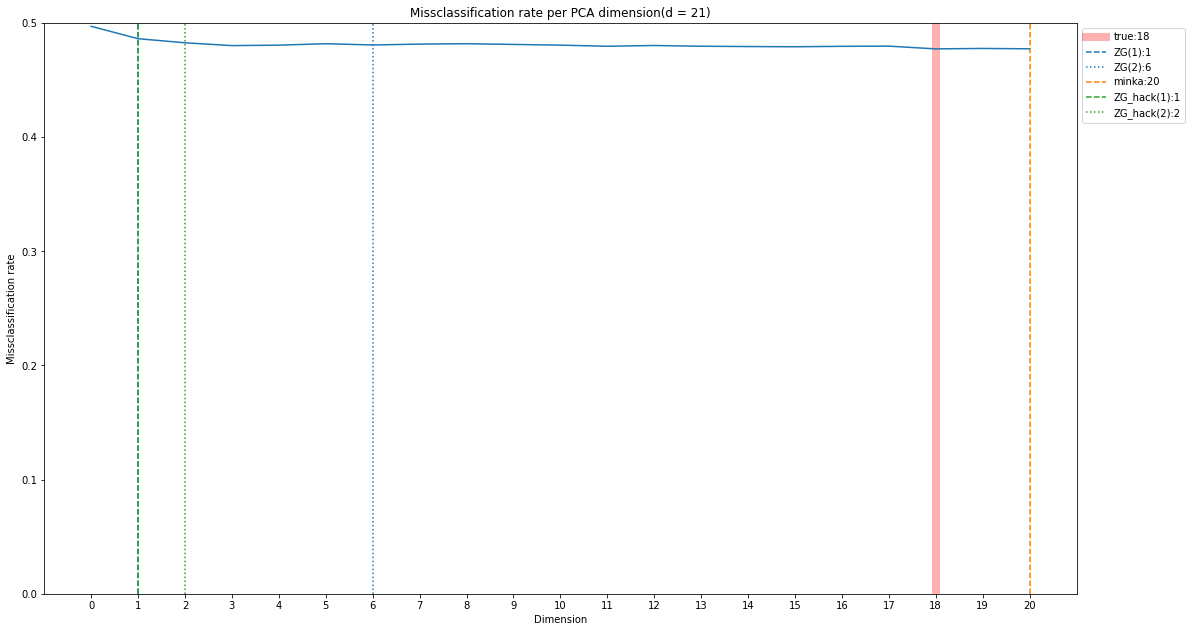

<Figure size 432x288 with 0 Axes>

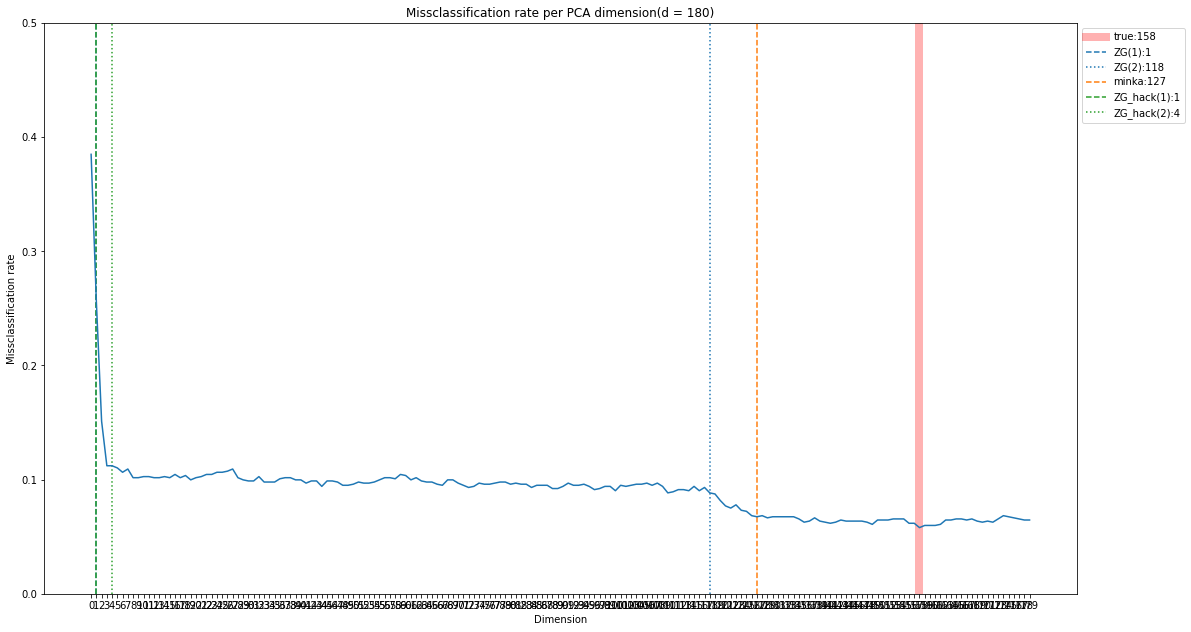

<Figure size 432x288 with 0 Axes>

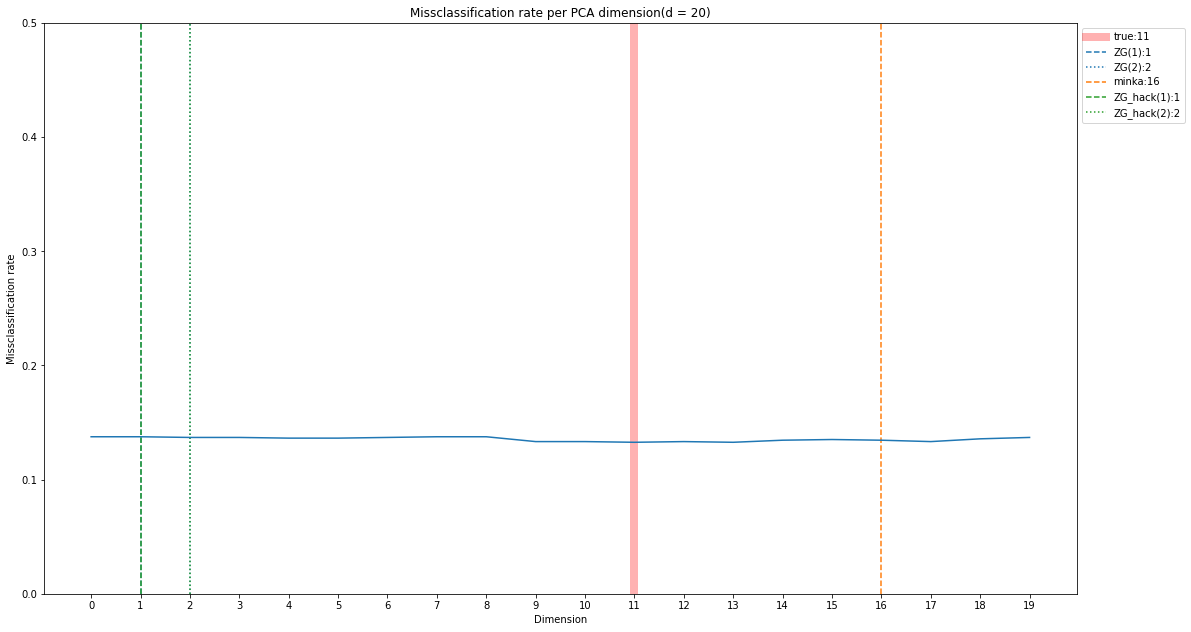

<Figure size 432x288 with 0 Axes>

In [51]:
from matplotlib import pyplot as plt
import os
true_LDA = []
direc = r'D:\Hopkins\Hopkins_senior\Neurodata\ndd_prac\ndd_stuff\sprint2\small_dim_select_LDA_true'
counter = 0
for i in range(len(all_miss)):
    idx = np.abs(np.asarray(all_miss[i]) +  np.min(np.asarray(all_miss[i])) * .05).argmin()
    true_LDA.append(idx)
    scree_2(all_miss[i], surv_dims[i], idx)     
    full_dir = os.path.join(direc, 'fig' + str(i) + '.png')
    plt.savefig(full_dir)
    plt.show()
    
with open('SMALL_true_LDA.pkl', 'wb') as f:
    pickle.dump(true_LDA, f)

In [52]:
def hist(true1, d1, d2, d3, d4, d5, true2):
    # true1 is from the LDA
    # true2 is from the survey from humans 
    d1 = np.asarray(d1)
    d2 = np.asarray(d2)
    d3 = np.asarray(d3)
    d4 = np.asarray(d4)
    d5 = np.asarray(d5)
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    x = [d1, d2, d3, d4, d5]
    labs = ['ZG(1):{}', 'ZG(2):{}', 'minka:{}', 'ZG_hack(1):{}', 'ZG_hack(2):{}']
    colors = sns.color_palette()
    for i in range(len(x)):
        sns.distplot(x[i], bins=range(np.min(np.asarray(x)) - 5, np.max(np.asarray(x)+ 5), 1), ax=ax, kde=True, hist = True, label = labs[i].format(np.median(np.asarray(x[i]))))
    plt.axvline(true1, label='LDA estimation:{}'.format(true1), color=colors[5], linewidth = 8, alpha = 1, zorder =  0, ls= ":")
    plt.axvline(true2, label='Survey Estimation:{}'.format(true2), color=colors[6], linewidth = 8, alpha = 1, zorder =  0, ls= "--")
    plt.title('Histogram')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left',)
    plt.show()

In [62]:
with open('SMALL_true_LDA.pkl', 'rb') as f:
    true_LDA = pickle.load(f)

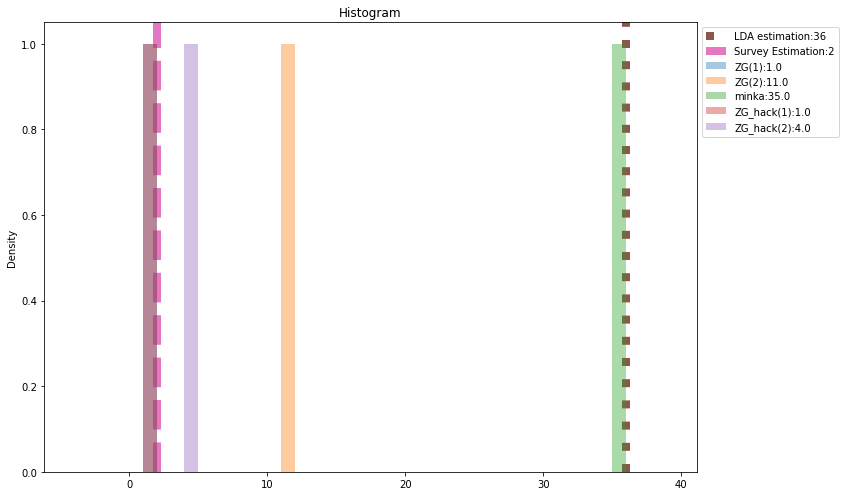

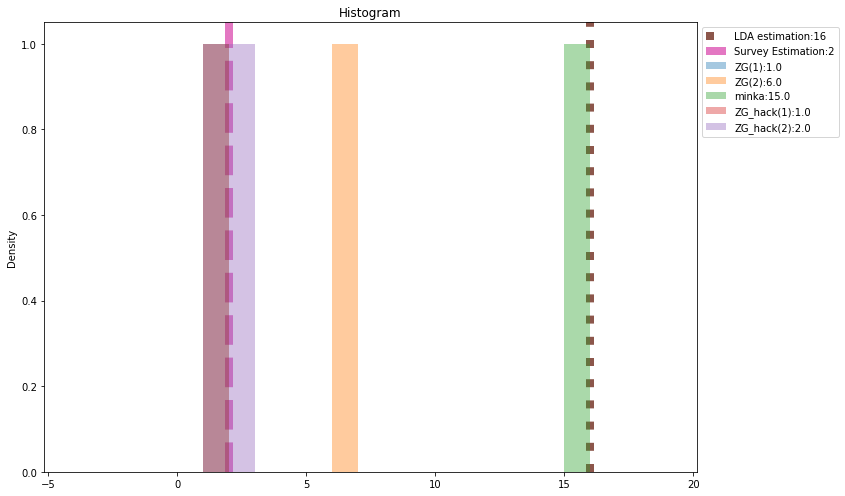

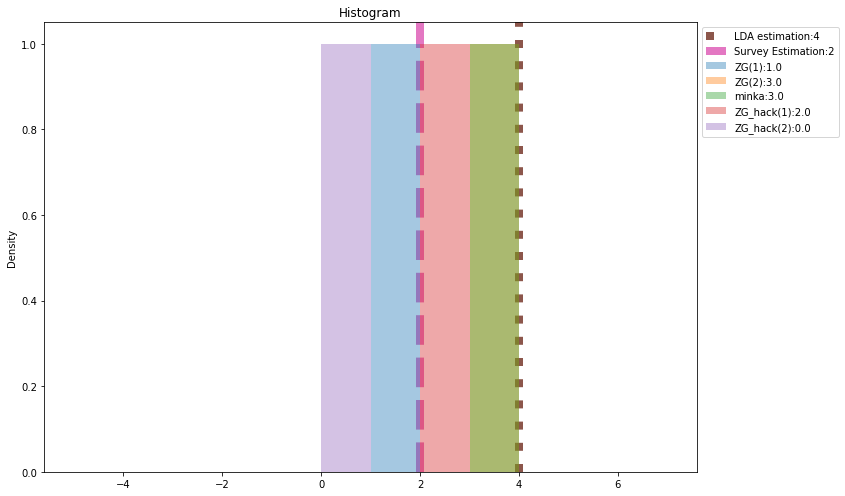

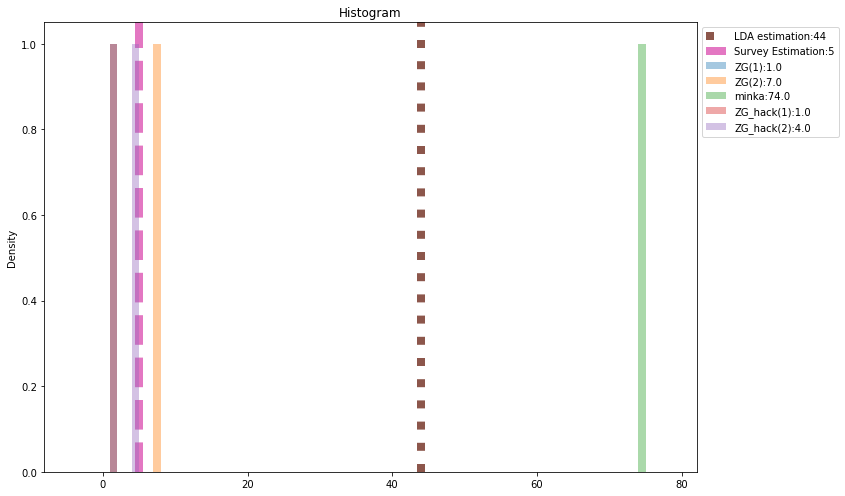

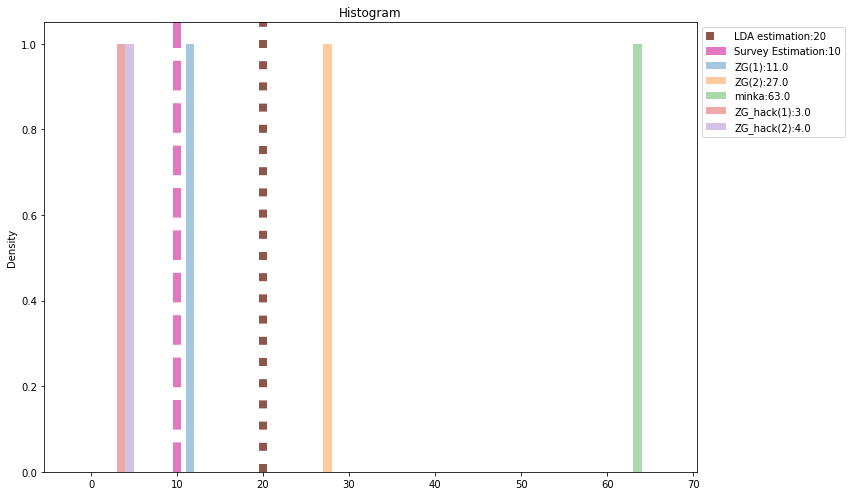

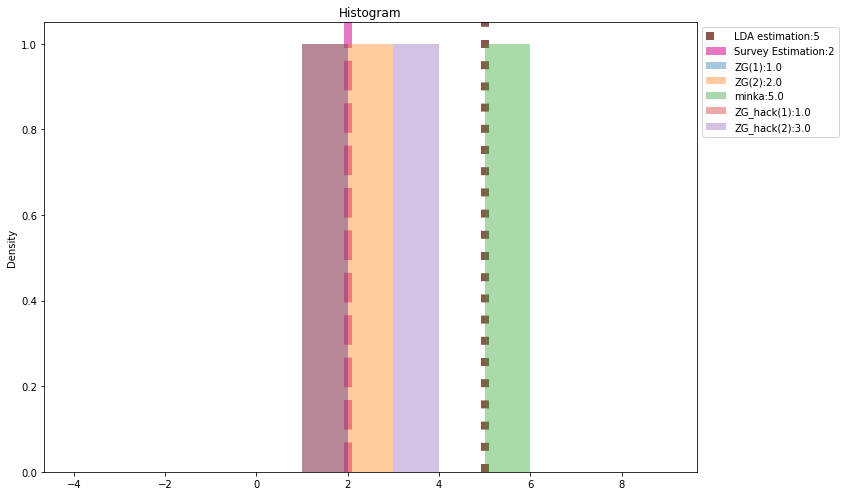

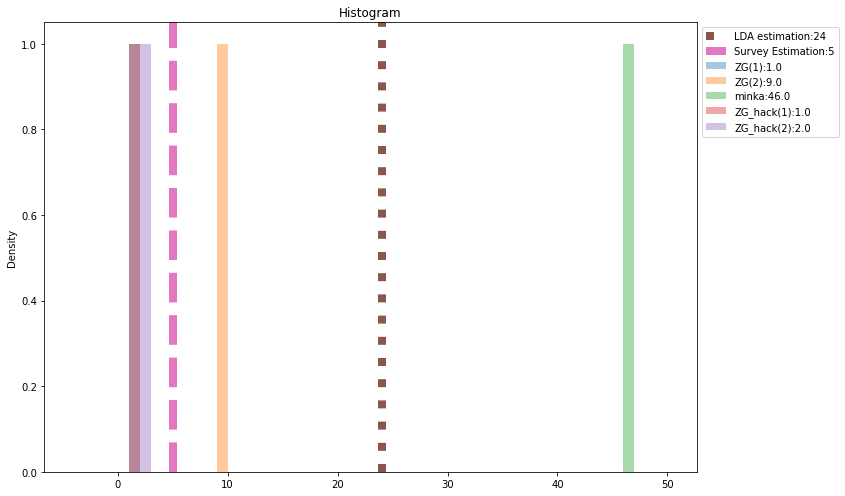

KeyboardInterrupt: 

In [54]:
import warnings
warnings.filterwarnings('ignore')
for i in range(len(all_miss)):
    hist(true_LDA[i] + 1, dims_ZG_1_all[i],dims_ZG_2_all[i],  dims_minka_all[i], dims_ZG_h_1_all[i], dims_ZG_h_2_all[i], true_survey[i])

In [63]:
len(dims_ZG_1_all)

46

In [64]:
len(true_LDA)

46

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


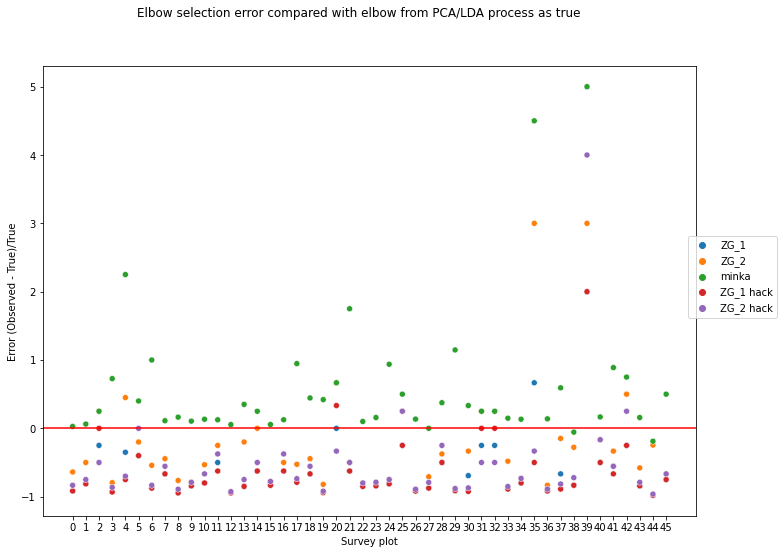

In [65]:
import seaborn as sns
fig, axes = plt.subplots(1, 1)
pca_lda_hist = []
for i in range(len(all_miss)):
    print(i)
    es = [(np.median(dims_ZG_1_all[i]) - true_LDA[i] + 1)/(true_LDA[i] + 1), 
          (np.median(dims_ZG_2_all[i]) - true_LDA[i] + 1)/(true_LDA[i] + 1),  
          (np.median(dims_minka_all[i]) - true_LDA[i] + 1)/ (true_LDA[i] + 1), 
          (np.median(dims_ZG_h_1_all[i]) - true_LDA[i] + 1)/(true_LDA[i] + 1), 
          (np.median(dims_ZG_h_2_all[i]) - true_LDA[i] + 1) /(true_LDA[i] + 1)]
    xs = [i]*5    
    sns.scatterplot(x = xs, y = es, hue = ["ZG_1", "ZG_2", "minka" , "ZG_1 hack", "ZG_2 hack"])
    pca_lda_hist.append(es)
axes.set_xticks(np.arange(len(all_miss)))  
handles, labels = axes.get_legend_handles_labels()
axes.legend().remove()
fig.legend(handles[:5], labels[:5], loc="center right")

fig.set_size_inches(11.7, 8.27)
fig.show()
plt.suptitle("Elbow selection error compared with elbow from PCA/LDA process as true")
axes.set_ylabel("Error (Observed - True)/True")
axes.set_xlabel("Survey plot")
plt.axhline(y=0, color='r', linestyle='-')
    

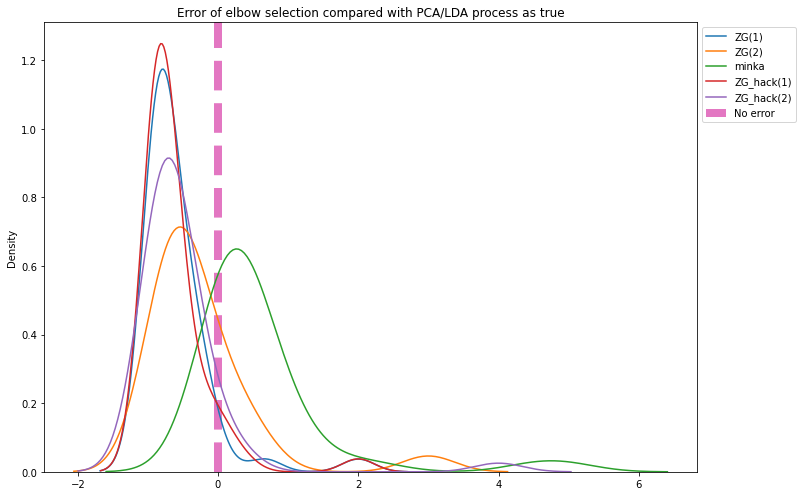

In [66]:
pca_lda_hist = np.asarray(pca_lda_hist)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
labs = ['ZG(1)', 'ZG(2)', 'minka', 'ZG_hack(1)', 'ZG_hack(2)']
colors = sns.color_palette()
for i in range(pca_lda_hist.shape[1]):
    sns.kdeplot(pca_lda_hist[:, i], ax=ax, label = labs[i] )

plt.axvline(0, label='No error', color=colors[6], linewidth = 8, alpha = 1, zorder =  0, ls= "--")
plt.title('Error of elbow selection compared with PCA/LDA process as true')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left',)
plt.show()

## Survey results median as true
We will need to send out a new survey as there are more plots now

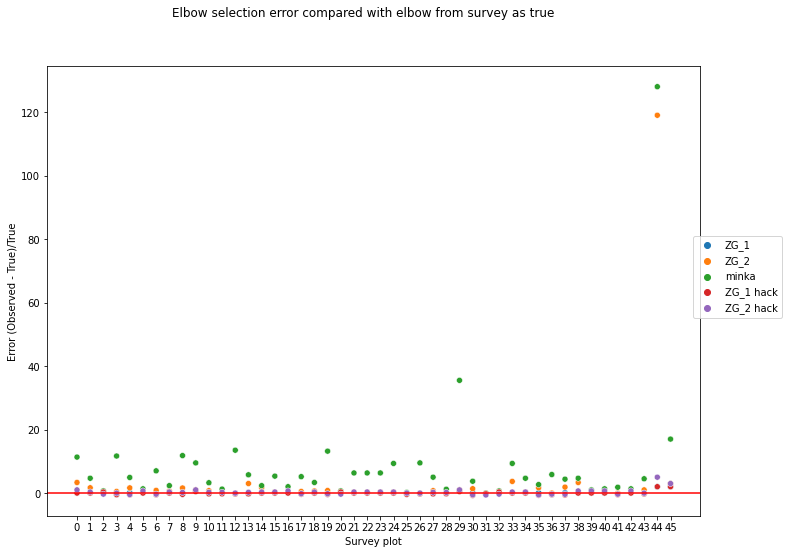

In [67]:
import seaborn as sns
fig, axes = plt.subplots(1, 1)

pca_surv_hist = []
for i in range(len(all_miss)):
    es = [(np.median(dims_ZG_1_all[i]) - true_survey[i] + 1)/(true_survey[i] + 1), 
          (np.median(dims_ZG_2_all[i]) - true_survey[i] + 1)/(true_survey[i] + 1),  
          (np.median(dims_minka_all[i]) - true_survey[i] + 1)/ (true_survey[i] + 1), 
          (np.median(dims_ZG_h_1_all[i]) - true_survey[i] + 1)/(true_survey[i] + 1), 
          (np.median(dims_ZG_h_2_all[i]) - true_survey[i] + 1) /(true_survey[i] + 1)]
    xs = [i]*5    
    sns.scatterplot(x = xs, y = es, hue = ["ZG_1", "ZG_2", "minka" , "ZG_1 hack", "ZG_2 hack"])
    pca_surv_hist.append(es)
axes.set_xticks(np.arange(len(all_miss)))  
handles, labels = axes.get_legend_handles_labels()
axes.legend().remove()
fig.legend(handles[:5], labels[:5], loc="center right")

fig.set_size_inches(11.7, 8.27)
fig.show()
plt.suptitle("Elbow selection error compared with elbow from survey as true")
axes.set_ylabel("Error (Observed - True)/True")
axes.set_xlabel("Survey plot")
plt.axhline(y=0, color='r', linestyle='-')
    

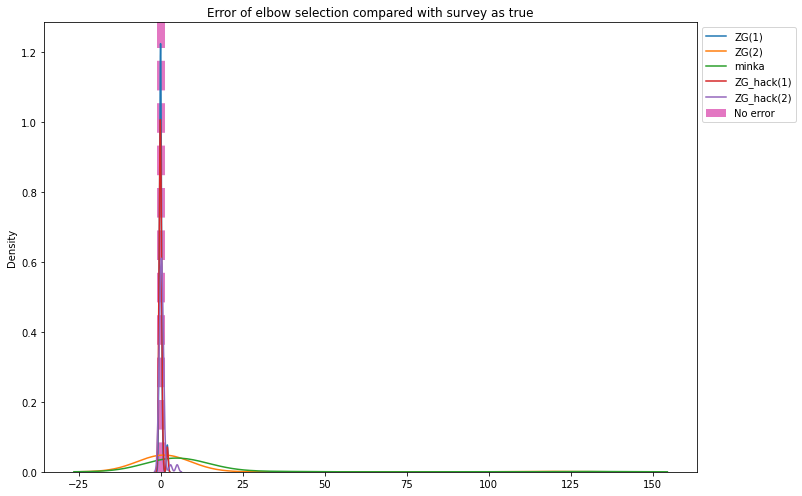

In [68]:
pca_surv_hist = np.asarray(pca_surv_hist)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
labs = ['ZG(1)', 'ZG(2)', 'minka', 'ZG_hack(1)', 'ZG_hack(2)']
colors = sns.color_palette()
for i in range(pca_surv_hist.shape[1]):
    sns.kdeplot(pca_surv_hist[:, i], ax=ax, label = labs[i] )

plt.axvline(0, label='No error', color=colors[6], linewidth = 8, alpha = 1, zorder =  0, ls= "--")
plt.title('Error of elbow selection compared with survey as true')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left',)
plt.show()

In [ ]:
changes : 
    do seaborn context
do rugplot